# Run GLMS
motor glm not interesting for openfmri dataset as they only used right hand

In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

import pandas as pd
import numpy as np
import shutil
import itertools
#import statannot

import glob
import re
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import scipy
import nideconv
from nideconv import GroupResponseFitter
from scipy import signal

import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.backends.backend_pdf

%matplotlib inline

def flatten(t):
    return [item for sublist in t for item in sublist]

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## functions

In [2]:
def to_psc(x): # calculate percent signal change
    return x / x.mean() * 100 - 100

def load_events_confounds(sub, dataset, task, run, include_physio=True, include_cosines=True):
    event_fn = f'../derivatives/event_files/{dataset}/sub-{sub}/func/sub-{sub}_task-{task}_run-{run}_events.tsv'
#    regressor_fn = f'../derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-model-regressors.tsv'
    confounds_fn = f'../derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-{sub}/func/sub-{sub}_task-{task}_run-{run}_desc-confounds_timeseries.tsv'
    
    events = pd.read_csv(event_fn, sep='\t', index_col=None)
    events['duration'] = .001
            
    # get confounds, cosines
    confounds = pd.read_csv(confounds_fn, sep='\t').fillna(method='bfill')
    include_confs = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'dvars', 'framewise_displacement', 'global_signal']
    if include_cosines:
        include_confs += [x for x in confounds.columns if 'cos' in x]
    confounds = confounds[include_confs]
    
    if include_physio:
        run_idx = run#+1
        # just use acompcor
        # some subjects have less than 20 acompcor components, so just take max amount if not more than 20
#         a_comp_cor = pd.read_csv(confounds_fn, sep='\t')[['a_comp_cor_' + str(x).zfill(2) for x in range(20)]]
        a_comp_cor = pd.read_csv(confounds_fn, sep='\t')
        if num_acopm:=len([col for col in a_comp_cor.columns if 'a_comp_cor_' in col]) < 20:
            a_comp_cor = a_comp_cor[['a_comp_cor_' + str(x).zfill(2) for x in range(num_acopm)]]
        else: # use normal 20
            a_comp_cor = a_comp_cor[['a_comp_cor_' + str(x).zfill(2) for x in range(20)]]
        confounds = pd.concat([confounds, a_comp_cor], axis=1)

    return events, confounds

# def load_timeseries(atlas_type='MASSP', dataset='Leipzig_7T_SM', task='msit'):

#     signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/{dataset}/sub-*/func/*task-{task}*{atlas_type}-signals*.tsv'))

#     regex = re.compile(f'.*sub-(?P<sub>\d+)_task-{task}_run-(?P<run>\d)_desc-{atlas_type}-signals.tsv')
#     dfs = []
#     for signal_fn in signal_fns:
#         signals = pd.read_csv(signal_fn, sep='\t')
#         gd = regex.match(signal_fn).groupdict()

#         if 'time' in signals.columns:
#             signals = signals.rename(columns={'time': 'volume'})


#         signals = signals.set_index(['volume']).apply(to_psc).reset_index()  # to PSC
#         signals['time'] = signals['volume'] * 1.38

#         del signals['volume']
#         signals['sub'] = gd['sub']
#         signals['run'] = int(gd['run'])
#         signals = signals.set_index(['sub', 'run', 'time'])
#         dfs.append(signals)

#     df = pd.concat(dfs)
    
#     return df

def sort_data(df, ses, task):
    
    all_events = []
    all_confounds = []

    for sub, run in df.reset_index().set_index(['sub', 'run']).index.unique():
    #     if sub == '010' and run == '2':    # no RETROICOR
    #         continue
#         if sub == '007' and run == '1':    # no RETROICOR
#             continue
        events, confounds = load_events_confounds(sub, ses, task, run, include_physio=True)
        events['sub'] = sub
        events['run'] = run
        confounds['sub'] = sub
        confounds['run'] = run

        all_events.append(events)
        all_confounds.append(confounds)

    events = pd.concat(all_events).set_index(['sub', 'run'])
    confounds = pd.concat(all_confounds).set_index(['sub', 'run'])

    events = events.rename(columns={'trial_type': 'event_type'})

    events['duration'] = 0.001  # stick function
        
    # make psc
    confounds['global_signal'] = (confounds['global_signal']-confounds['global_signal'].mean())/confounds['global_signal'].std()

    # change subject number ordering
    subs = df.reset_index()['sub'].unique()
    mapping = {y:x+1 for x,y in enumerate(subs)}

    events = events.reset_index()
    events['sub'] = events['sub'].replace(mapping).astype(str)
    events = events.set_index(['sub', 'run'])

    df = df.reset_index()
    df['sub'] = df['sub'].replace(mapping).astype(str)
    df = df.set_index(['sub', 'run', 'time'])

    confounds = confounds.reset_index()
    confounds['sub'] = confounds['sub'].replace(mapping).astype(str)
    confounds = confounds.set_index(['sub', 'run'])

    events.index = events.index.rename('subject', level=0)
    df.index = df.index.rename('subject', level=0)
    confounds.index = confounds.index.rename('subject', level=0)
    
    return events, df, confounds


In [3]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

## start running

In [4]:
# which dataset?
# dataset = 'Leipzig_7T_SM'
# dataset = 'Leipzig_7T_GdH'
# dataset = 'NTNU_7T_SJSI'
dataset = 'openfmri_3T'

In [5]:
if dataset == 'Leipzig_7T_GdH':
    task = 'stop'
    t_r = 2.0
    runs = [1,2,3]
    excluded_runs = [('GAIT', '2'),
                 ('GAIT', '3'),
                 ('NM3T', '2'),
                 ('PF5T', '1')]
    
elif dataset == 'Leipzig_7T_SM':
    task = 'stop'
    t_r = 3.0
    runs = [1,2,3]
    excluded_runs = []
    
elif dataset == 'NTNU_7T_SJSI':
    task = 'sst'
    t_r = 1.38
    runs = [1,2]
    excluded_runs = []
    
elif dataset == 'openfmri_3T':
    task = 'stopsignal'
    t_r = 2.0
    runs = [1]
    excluded_runs = [('10570',task,'1')]

In [6]:
# # collect together all regions of interest for each sub.
subs = [x.split('/')[-1].split('-')[-1] for x in glob.glob(f'../derivatives/extracted_signals/{dataset}/sub-*')]
# print(len(subs)) 

# for hp in ['','_hp']:
#     for sub in subs:
#     #     print(sub)
#         for run in runs:
#     #         print(run)
#             all_sigs = []#pd.DataFrame()
#             signals = sorted(glob.glob(f'../derivatives/extracted_signals/{dataset}/sub-{sub}/func/*task-{task}_run-{run}*-signals{hp}.tsv'))
#             if signals == []:
#                 print(f'no data for sub {sub} run {run} task {task}')
#                 continue
#             signals = [x for x in signals if 'ALL' not in x]
#             for index, sig in enumerate(signals):
#                 if index == 0:
#                     all_sigs = pd.read_csv(sig, sep='\t')
#                 else:
#                     all_sigs = pd.concat([all_sigs, pd.read_csv(sig, sep='\t')],axis=1)

#             all_sigs = all_sigs.loc[:,~all_sigs.columns.duplicated()]
#             all_sigs.to_csv(sig.replace('harvard','ALL'),'\t') # replace last loaded mask name with ALL


In [35]:
signals

,Caudate-l,Caudate-r,IFG-l,IFG-r,M1-l,M1-r,Putamen-l,Putamen-r,gpe-l,gpe-r,...,preSMA-l,preSMA-r,sn-l,sn-r,stn-l,stn-r,tha-l,tha-r,vta-l,vta-r
volume,,,,,,,,,,,,,,,,,,,,,
0,0.211964,0.084165,0.679166,-0.477105,-0.074566,-0.143394,0.222904,-0.298039,0.317157,0.010732,...,-0.079060,-0.305217,-0.469590,-0.368115,1.783816,0.253668,0.166438,-0.117417,-0.947428,-0.274663
1,-0.340036,-0.443594,-0.376125,-0.463421,0.063099,0.049391,-0.246891,-0.164282,-0.534620,0.036789,...,0.248478,0.012308,0.536556,0.576987,-1.465925,0.241878,-0.104189,-0.194371,0.560031,0.674010
2,0.257802,-0.025966,0.504030,0.212249,-0.001200,0.269173,0.175959,0.127612,0.436532,0.104356,...,-0.016889,0.071394,0.112904,-0.217922,0.750745,-0.707195,-0.125225,-0.110848,0.331951,-0.757380
3,0.135430,0.090361,-0.147644,0.062456,0.391943,0.196825,0.247854,0.377268,0.324205,0.261130,...,0.075299,0.338119,0.355981,-0.017226,1.071772,1.446079,-0.023791,-0.055390,-0.283054,0.235509
4,0.241855,0.494397,0.301212,0.156945,-0.301110,-0.259287,0.290529,0.321138,-0.003490,0.377894,...,0.134888,0.115813,0.704033,-0.012909,-1.102245,0.982521,0.073356,0.104509,0.089030,0.341653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,0.131253,0.097506,0.514816,-0.140503,-0.792274,-0.227261,-0.385944,-0.397991,0.267005,0.116215,...,-0.110527,-0.133689,0.227555,0.006033,0.010485,-0.971303,-0.021521,-0.263134,0.533392,0.013487
180,-0.184365,-0.342597,0.426251,0.279380,-0.280655,0.014132,-0.447319,-0.269357,-0.197993,-0.035544,...,-0.080435,-0.285414,-0.531931,-0.235509,-0.171201,-0.906172,-0.291876,-0.265397,-0.534341,-0.309466
181,0.000971,0.068405,0.309442,0.317510,-0.073917,-0.078802,0.093087,0.021774,-0.216604,-0.190906,...,0.025772,0.231019,0.258517,0.286440,-1.314749,0.403062,0.046047,0.014917,0.657004,-0.072571


In [39]:
## Load timeseries
atlas_type = 'useful'
signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/{dataset}/sub-*/func/*task-{task}*{atlas_type}*signals.tsv'))
# signal_fns = [x for x in signal_fns if not any(s in x for s in to_remove)] # remove subs that didnt do task right
# signal_fns = signal_fns[:15]

filter_out_confounds = True
filter_hp = False # already highpassed so no need

regex = re.compile(f'.*sub-(?P<sub>[a-zA-Z0-9]+)_task-(?P<task>\S+)_run-(?P<run>\d)_desc-{atlas_type}-signals.tsv')
dfs = []
for signal_fn in signal_fns:
    signals = pd.read_csv(signal_fn, sep='\t',index_col=0)
    gd = regex.match(signal_fn).groupdict()
    if tuple(gd.values()) in excluded_runs:
        # run was excluded
        print(tuple(gd.values()))
        continue
    
#     if 'time' in signals.columns:
#         # if there's a column named 'time', it's called 'time' but it's really volume number..
#         signals = signals.rename(columns={'time': 'volume'})
    # signals = signals.set_index('volume')
# #     print(signals)
    # psc?
    signals = signals.apply(to_psc)  # to PSC
#     print(signals)

    # filter out confounds?
    if filter_out_confounds:
        
#         print(gd['sub'])
        _, confounds = load_events_confounds(sub=gd['sub'], dataset=dataset, task=gd['task'], run=gd['run'])
        confounds['intercept'] = 1   # add intercept!
        betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
        signals_hat = confounds@betas
        signals_hat.index = signals.index
        signals_hat.columns = signals.columns
        signals -= signals_hat   # residuals
        
    # high pass?
    if filter_hp:
        signals = signals.apply(lambda x: butter_highpass_filter(x, cutoff=1/128, fs=1/t_r) + x.mean(), axis=0)
        
#    print(signals.columns)
    signals = signals[['Caudate-l', 'Caudate-r', 'IFG-l', 'IFG-r', 'M1-l', 'M1-r', 'Putamen-l',
       'Putamen-r', 'gpe-l', 'gpe-r', 'gpi-l', 'gpi-r', 'preSMA-l', 'preSMA-r',
       'sn-l', 'sn-r', 'stn-l', 'stn-r', 'tha-l', 'tha-r', 'vta-l', 'vta-r']]
    

    # index to time
    signals.index *= t_r
    signals.index.name = 'time'
    signals['subject'] = gd['sub']
    signals['run'] = int(gd['run'])
    signals = signals.reset_index().set_index(['subject', 'run', 'time'])
    dfs.append(signals)
    
df = pd.concat(dfs)
df = df.reindex(sorted(df.columns), axis=1)

if atlas_type == 'ALL':
    df.rename(columns = {'lM1':'M1-l', 'rM1':'M1-r', 'gpel':'GPe-l','gper':'GPe-r','gpil':'GPi-l','gpir':'GPi-r',
                         'rnl':'RN-l','rnr':'RN-r','snl':'SN-l','snr':'SN-r','stnl':'STN-l','stnr':'STN-r',
                         'strl':'Str-l','strr':'Str-r','thal':'Tha-l','thar':'Tha-r','vtal':'VTA-l','vtar':'VTA-r'}, inplace = True)
#     rois_ = sorted(['IFG-l','IFG-r','ACC-l','ACC-r','M1-l','M1-r','SMA-l','SMA-r','PaCG-l','PaCG-r','Ins-l','Ins-r','GPe-l','GPe-r','GPi-l','GPi-r','RN-l','RN-r','SN-l','SN-r',
#              'STN-l','STN-r','Str-l','Str-r','Tha-l','Tha-r','VTA-l','VTA-r'])
#     rois_ = ['ACC-l','ACC-r','IFG-l','IFG-r','Ins-l','Ins-r','M1-l','M1-r','pSG-l','pSG-r','SMA-l','SMA-r','SPL-l','SPL-r','GPe-l','GPe-r','GPi-l','GPi-r','RN-l','RN-r','SN-l','SN-r',
#              'STN-l','STN-r','Str-l','Str-r','Tha-l','Tha-r','VTA-l','VTA-r']
    
    rois_ = ['IFG','SMA','M1','SN','STN','GPe','Tha']
    rois_ = [roi + '-' + hemi for roi in rois_ for hemi in ['l', 'r']]
    # all cortical masks from harvard-oxford atlas
    # all subcortical masks from MASSP atalas
    df = df[rois_]
    
elif atlas_type == 'ATAG':
    rois_ = ['lM1','rM1','lPreSMA','rPreSMA','rIFG','lSTN','rSTN','lSN','rSN']#,'ACC','THA']
    df = df[rois_]
    
# os.makedirs(timeseries_dir:=f'../derivatives/hierarchical_roi_glm/{dataset}/timeseries', exist_ok=True)
# with open(os.path.join(timeseries_dir, f'{dataset}_timeseries.pkl'), 'wb') as f:
#             pkl.dump('', f)
# with open(os.path.join(timeseries_dir, f'{dataset}_timeseries.pkl'), 'wb') as f:
#             pkl.dump(df, f)

df.head()

/tmp/ipykernel_115851/871251248.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_115851/871251248.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_115851/871251248.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and

('10570', 'stopsignal', '1')


/tmp/ipykernel_115851/871251248.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_115851/871251248.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_115851/871251248.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and

Caudate-l  Caudate-r     IFG-l     IFG-r      M1-l  \
subject run time                                                       
10159   1   0.0    0.211964   0.084165  0.679166 -0.477105 -0.074566   
            2.0   -0.340036  -0.443594 -0.376125 -0.463421  0.063099   
            4.0    0.257802  -0.025966  0.504030  0.212249 -0.001200   
            6.0    0.135430   0.090361 -0.147644  0.062456  0.391943   
            8.0    0.241855   0.494397  0.301212  0.156945 -0.301110   

                      M1-r  Putamen-l  Putamen-r     gpe-l     gpe-r  ...  \
subject run time                                                      ...   
10159   1   0.0  -0.143394   0.222904  -0.298039  0.317157  0.010732  ...   
            2.0   0.049391  -0.246891  -0.164282 -0.534620  0.036789  ...   
            4.0   0.269173   0.175959   0.127612  0.436532  0.104356  ...   
            6.0   0.196825   0.247854   0.377268  0.324205  0.261130  ...   
            8.0  -0.259287   0.290529   0.321138 -0.003490  0.377894  ...   

                  preSMA-l  preSMA-r      sn-l      sn-r     stn-l     stn-r  \
subject run time                                                               
10159   1   0.0  -0.079060 -0.305217 -0.469590 -0.368115  1.783816  0.253668   
            2.0   0.248478  0.012308  0.536556  0.576987 -1.465925  0.241878   
            4.0  -0.016889  0.071394  0.112904 -0.217922  0.750745 -0.707195   
            6.0   0.075299  0.338119  0.355981 -0.017226  1.071772  1.446079   
            8.0   0.134888  0.115813  0.704033 -0.012909 -1.102245  0.982521   

                     tha-l     tha-r     vta-l     vta-r  
subject run time                                          
10159   1   0.0   0.166438 -0.117417 -0.947428 -0.274663  
            2.0  -0.104189 -0.194371  0.560031  0.674010  
            4.0  -0.125225 -0.110848  0.331951 -0.757380  
            6.0  -0.023791 -0.055390 -0.283054  0.235509  
            8.0   0.073356  0.104509  0.089030  0.341653  

[5 rows x 22 columns]

## load event, confounds

In [40]:
model_n = 'all_events'
all_events = []
all_confounds = []

for sub, run in df.reset_index().set_index(['subject', 'run']).index.unique():
    events, confounds = load_events_confounds(sub, dataset, task, run, include_physio=True)
    events['subject'] = sub
    events['run'] = run
    confounds['subject'] = sub
    confounds['run'] = run
    
    all_events.append(events)
    all_confounds.append(confounds)
    
events = pd.concat(all_events).set_index(['subject', 'run'])
confounds = pd.concat(all_confounds).set_index(['subject', 'run'])

events = events.rename(columns={'trial_type': 'event_type'})

events['duration'] = 0.001  # stick function

# os.makedirs(event_dir:=f'../derivatives/hierarchical_roi_glm/{dataset}/events', exist_ok=True)
# with open(os.path.join(event_dir, f'{dataset}_events.pkl'), 'wb') as f:
#             pkl.dump('', f)
# with open(os.path.join(event_dir, f'{dataset}_events.pkl'), 'wb') as f:
#             pkl.dump(events, f)
        
# os.makedirs(confound_dir:=f'../derivatives/hierarchical_roi_glm/{dataset}/confounds', exist_ok=True)
# with open(os.path.join(confound_dir, f'{dataset}_confounds.pkl'), 'wb') as f:
#             pkl.dump('', f)
# with open(os.path.join(confound_dir, f'{dataset}_confounds.pkl'), 'wb') as f:
#             pkl.dump(confounds, f)

## glm function

In [41]:
def fit_glm(timeseries, events, confounds, include_events, include_rois, t_r=t_r, oversample_design_matrix=10, concatenate_runs=False, fit_type='ols'):
    events_1 = events.reset_index().set_index(['subject', 'run', 'event_type']).loc[(slice(None), slice(None), include_events),:]
    events_1 = events_1.reset_index().set_index(['subject', 'run', 'event_type'])
    events_1.onset -= t_r/2   # stc

    glm1 = GroupResponseFitter(timeseries.copy()[include_rois],
                               events_1, 
                               confounds=confounds.copy().reset_index() if confounds is not None else None,
                               input_sample_rate=1/t_r, 
                               oversample_design_matrix=oversample_design_matrix,
                               concatenate_runs=concatenate_runs)
    for event_type in include_events:
#         if event_type in ['stimulus_value_difference', 'feedback_PE']:
#             glm1.add_event(event_type, covariates='modulation', basis_set='canonical_hrf', interval=[0, 19.32])
#         else:
        glm1.add_event(event_type, basis_set='canonical_hrf_with_time_derivative',  interval=[0, 18])

    glm1.fit(type=fit_type)
    return glm1

# fit event glm

In [42]:
# if atlas_type == 'ATAG':
#     gm_nuclei = ['M1', 'PreSMA', 'IFG'] #'ACC',
#     include_rois = [hemi + roi for roi in gm_nuclei for hemi in ['l','r']]
#     include_rois.remove('lIFG')
if atlas_type == 'ATAG':
    gm_nuclei = ['M1', 'PreSMA', 'IFG','STN','SN'] #'ACC',
    include_rois = [hemi + roi for roi in gm_nuclei for hemi in ['l','r']]
    include_rois.remove('lIFG')
#     include_rois += ['ACC', 'THA']
elif atlas_type=='MASSP':
    gm_nuclei = ['Amg', 'Cl', 'GPe', 'GPi', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'Str', 'Tha', 'VTA']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
elif atlas_type == 'CORT':
    gm_nuclei = ['ACC','aSG','IFG','Ins','PaCG','pCC','postcG','precC','precGy','pSG','SMA','SPL']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
# elif atlas_type == 'ALL':
#     #     gm_nuclei = sorted(['IFG','ACC','M1','SMA','PaCG','Ins','GPe','GPi','RN','SN','STN','Str','Tha','VTA'])
#     gm_nuclei = ['ACC','IFG','Ins','M1','pSG','SMA','SPL','GPe','GPi','RN','SN','STN','Str','Tha','VTA']
#     include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
elif atlas_type == 'ALL':
    gm_nuclei = ['IFG','SMA','M1','SN','STN','GPe','Tha']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]

# include_events=['response_left','response_right','fs','ss','go']
include_rois = [x for x in df.columns]
include_events = ['fs','ss','go']
confounds=None
glm1 = fit_glm(timeseries=df, events=events, confounds=confounds, include_events=include_events, include_rois=include_rois)

/home/stevenm/miniconda3/lib/python3.9/site-packages/nideconv/group_analysis.py:87: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response_fitters = pd.Series(index=index)
/home/stevenm/miniconda3/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/stevenm/miniconda3/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/stevenm/miniconda3/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keywo

In [50]:
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go', 'fs', 'ss'], 'intercept', 'HRF')]                  # Select only betas of interest
#subjectwise_betas.loc[(slice(None),'fs','intercept','HRF')]
roiwise_betas = subjectwise_betas.loc[(slice(None),slice(None),'intercept','HRF')]
roiwise_betas = roiwise_betas.reset_index().melt(id_vars=['subject', 'event type'], var_name='ROI', value_name='cope')
roiwise_betas['roi_nohemi'] = roiwise_betas['ROI'].apply(lambda x: x.split('-')[0])
roiwise_betas['hemisphere'] = roiwise_betas['ROI'].apply(lambda x: x.split('-')[1])
roiwise_betas['roi_nohemi'] = roiwise_betas['roi_nohemi'].replace({'gpi': 'GPi', 
                                                                   'gpe': 'GPe', 
                                                                   'SMA': 'preSMA', 
                                                                   'sn':'SN', 'stn':'STN', 'm1':'M1', 'preSMA':'SMA', 'tha':'Tha', 'vta':'VTA'})
roiwise_betas['ROI'] = roiwise_betas['roi_nohemi'] + '-' + roiwise_betas['hemisphere']
roiwise_betas['dataset'] = 'openfmri_3T'
roiwise_betas.to_csv('../derivatives/copes_roi_analysis_nideconv_openfmri.tsv', sep='\t', index=False)

In [48]:
roiwise_betas

,subject,event type,ROI,cope,roi_nohemi,hemisphere,dataset
0,10159,go,Caudate-l,-0.077362,Caudate,l,openfmri_3T
1,10171,go,Caudate-l,0.008467,Caudate,l,openfmri_3T
2,10206,go,Caudate-l,0.072340,Caudate,l,openfmri_3T
3,10217,go,Caudate-l,-0.040017,Caudate,l,openfmri_3T
4,10228,go,Caudate-l,-0.051567,Caudate,l,openfmri_3T
...,...,...,...,...,...,...,...
6331,11128,ss,VTA-r,0.108332,VTA,r,openfmri_3T
6332,11131,ss,VTA-r,0.007019,VTA,r,openfmri_3T
6333,11143,ss,VTA-r,0.072730,VTA,r,openfmri_3T
6334,11149,ss,VTA-r,-0.027795,VTA,r,openfmri_3T


/home/stevenm/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


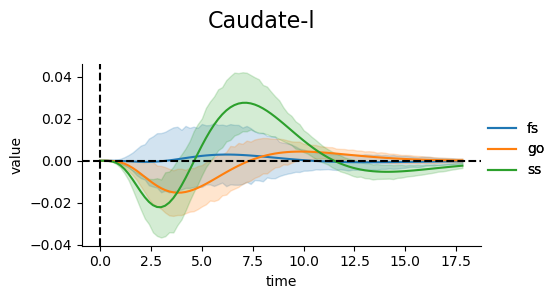

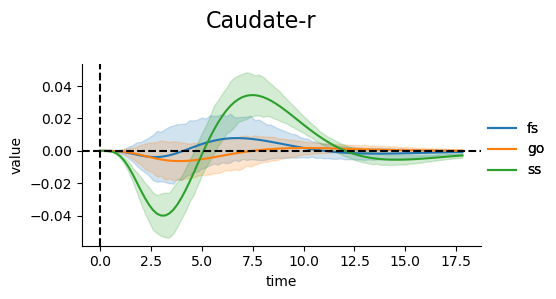

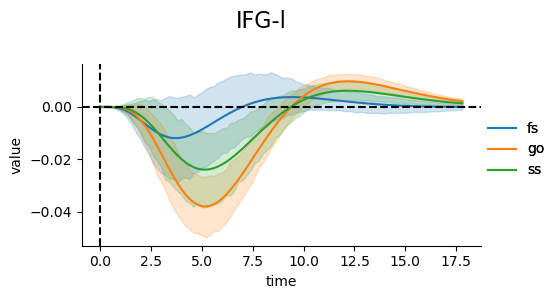

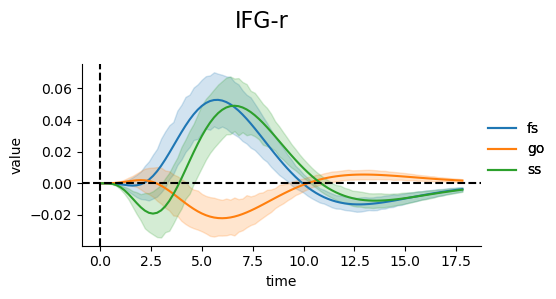

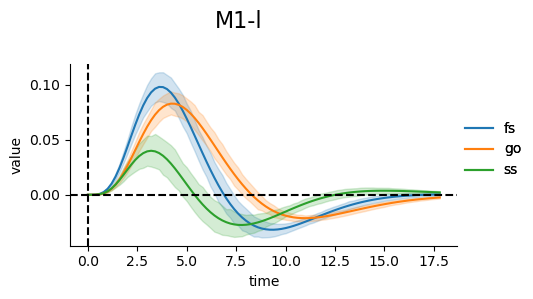

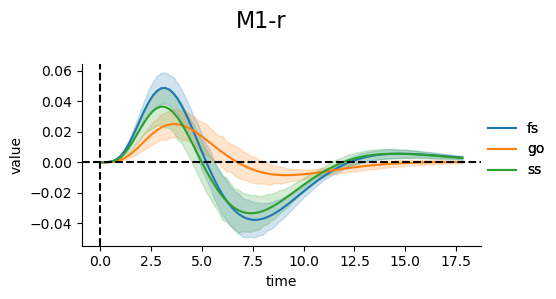

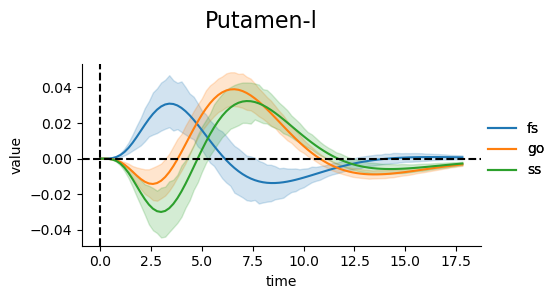

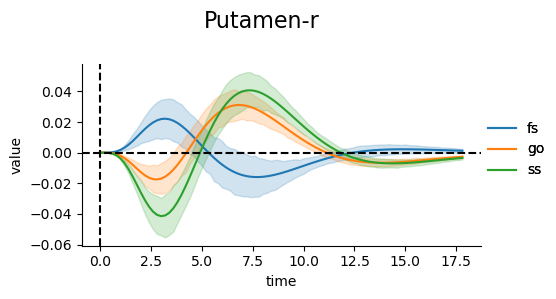

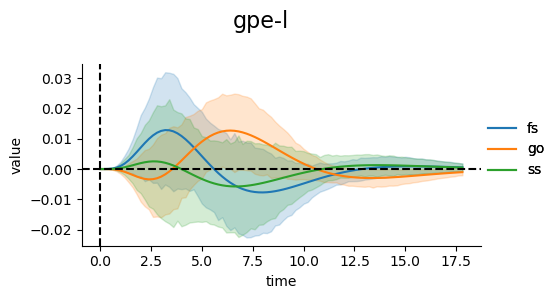

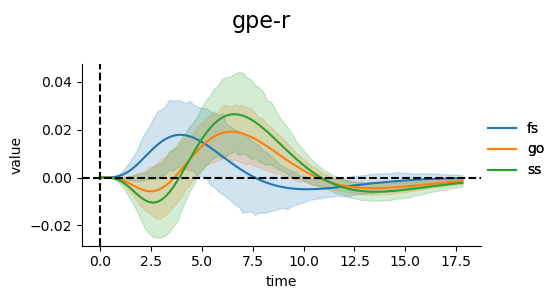

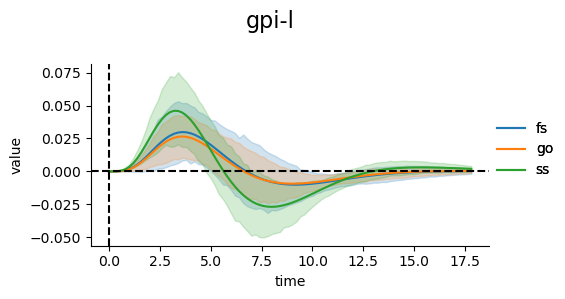

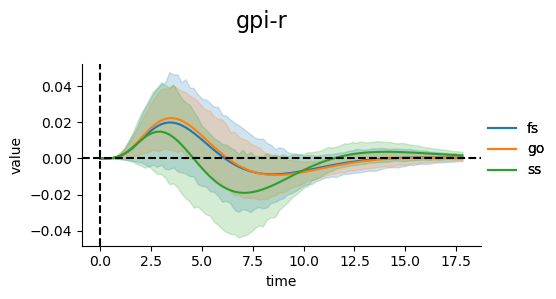

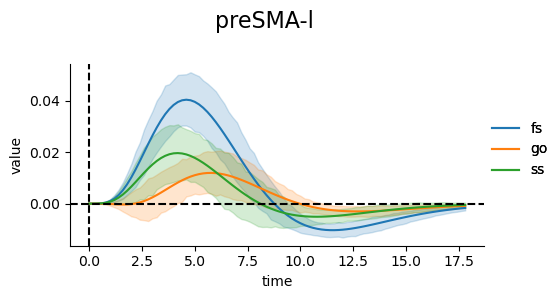

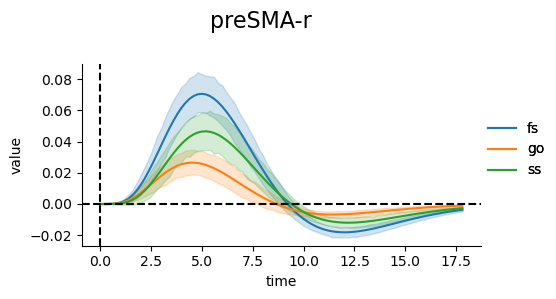

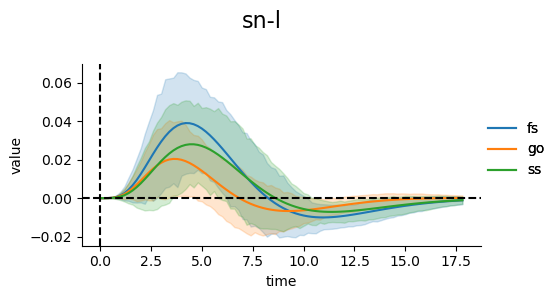

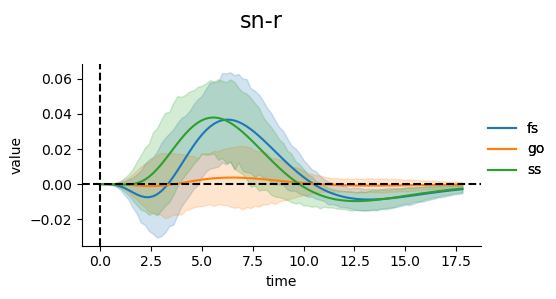

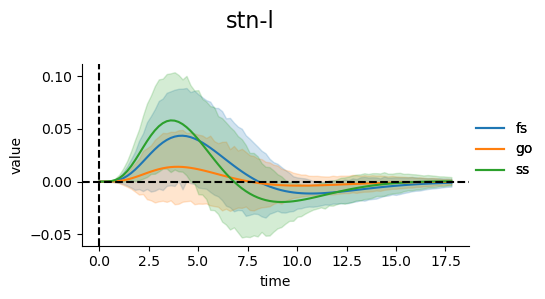

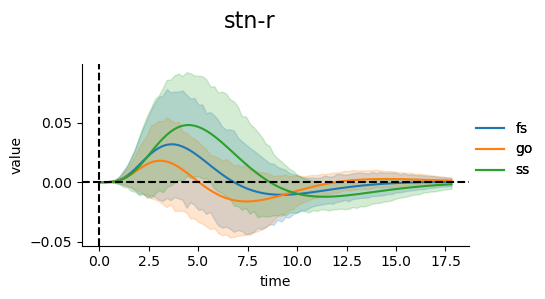

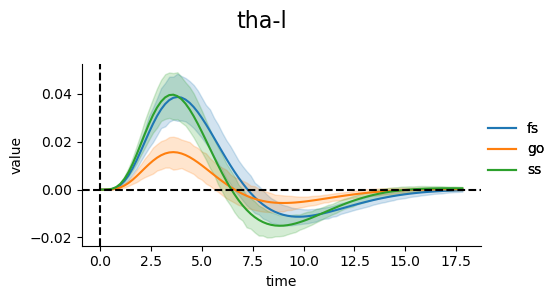

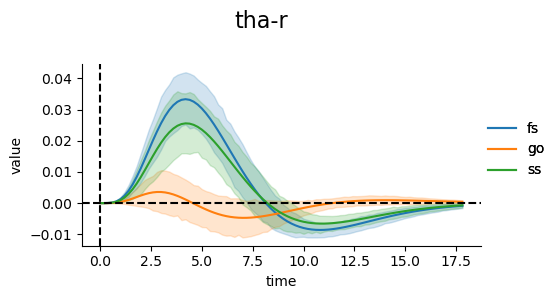

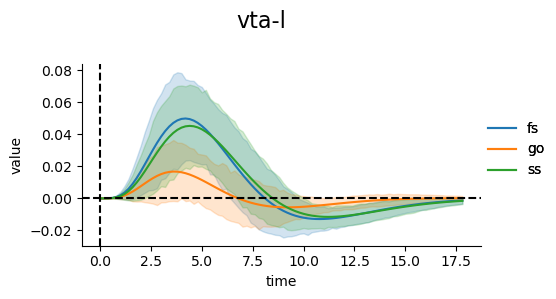

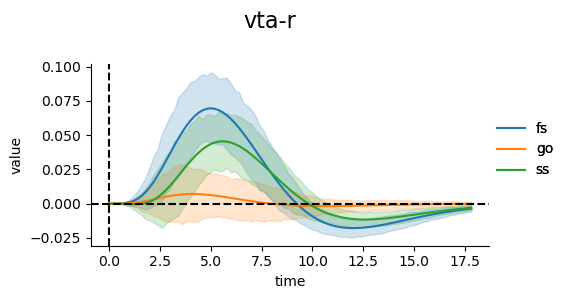

In [45]:
glm1.plot_groupwise_timecourses()

In [55]:
all_subjects = subjectwise_betas.loc[(slice(None),'fs','intercept','HRF')].index.tolist()
# all_subjects

In [82]:
import nibabel as nib
## Compare with FEAT
def get_mni_roi_masks():
    
    masks = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/sourcedata/useful_masks_mni09c1mm/*'))
#     masks = [x for x in masks if 'm1' not in x]
    
    return masks

all_masks = get_mni_roi_masks()

dfs = []
for subject in all_subjects:
    print(subject)
#    firstlevel_zstat_voxelwise = f'../derivatives/glm_feat_hp_sct/subject_level_model/openfmri_3T/sub-{subject}/func/fwhm-5p0/model-0/sub-{subject}_task-stopsignal_space-MNI152NLin2009cAsym_model-0_contrast-0_desc-zstat.nii.gz'
#    firstlevel_cope_roiwise = f'../derivatives/glm_feat_hp_sct/subject_level_model/openfmri_3T/sub-{subject}/func/fwhm-5p0/model-0/sub-{subject}_task-stopsignal_space-MNI152NLin2009cAsym_model-0_contrast-0_desc-cope.nii.gz'
    firstlevel_cope_roiwise = f'../derivatives/glm_feat_sst_roi/subject_level_model/openfmri_3T/sub-{subject}/func/model-0/sub-{subject}_task-stopsignal_space-MNI152NLin2009cAsym_model-0_contrast-0_desc-cope.nii.gz'
    firstlevel_zstat_roiwise = f'../derivatives/glm_feat_sst_roi/subject_level_model/openfmri_3T/sub-{subject}/func/model-0/sub-{subject}_task-stopsignal_space-MNI152NLin2009cAsym_model-0_contrast-0_desc-zstat.nii.gz'
    nii_cope = nib.load(firstlevel_cope_roiwise)
    nii_roiwise = nib.load(firstlevel_zstat_roiwise)
    copes_roiwise = nii_cope.get_fdata()
    zstats_roiwise = nii_roiwise.get_fdata()
    
    for mask in all_masks:
        mask_data = nib.load(mask).get_fdata()

        cope_roiwise = copes_roiwise[mask_data>0.5].mean()
#        std_zstat_voxelwise = zstats_voxelwise[mask_data>0.5].std()
        mean_zstat_roiwise = zstats_roiwise[mask_data>0.5].mean()

        dfs.append(pd.DataFrame({'cope_roiwise': cope_roiwise, 'zstat_roiwise': mean_zstat_roiwise, 'subject':subject}, index=mask.split('-')[-2:-1])) 

10159
10171
10206
10217
10228
10235
10249
10273
10274
10280
10290
10292
10304
10316
10321
10325
10329
10339
10340
10345
10347
10356
10361
10365
10388
10429
10438
10440
10448
10455
10460
10471
10478
10487
10492
10506
10517
10523
10524
10525
10557
10565
10575
10624
10629
10631
10638
10668
10674
10680
10686
10692
10697
10704
10707
10708
10719
10724
10746
10762
10779
10785
10788
10844
10871
10882
10891
10893
10934
10940
10958
10963
10968
10975
10977
10987
11019
11030
11044
11059
11061
11066
11067
11068
11077
11088
11090
11097
11098
11104
11108
11128
11131
11143
11149
11156


In [86]:
df = pd.concat(dfs)
df['hemisphere'] = ['l', 'r'] * int(df.shape[0]/2)
df.index.name='roi'
df = df.reset_index()
df.roi = df.roi.replace({'gp': 'GP', 'sn':'SN', 'stn':'STN', 'm1':'M1', 'preSMA':'SMA', 'tha':'THA', 'vta':'VTA'})
df['ROI'] = df['roi'] + '-' + df['hemisphere']
roiwise_betas = subjectwise_betas.loc[(slice(None),'fs','intercept','HRF')]
roiwise_betas = roiwise_betas.reset_index().melt(id_vars=['subject'], var_name='ROI', value_name='cope')

In [87]:
combined = pd.merge(roiwise_betas, df, on=['subject', 'ROI'])
combined.head()

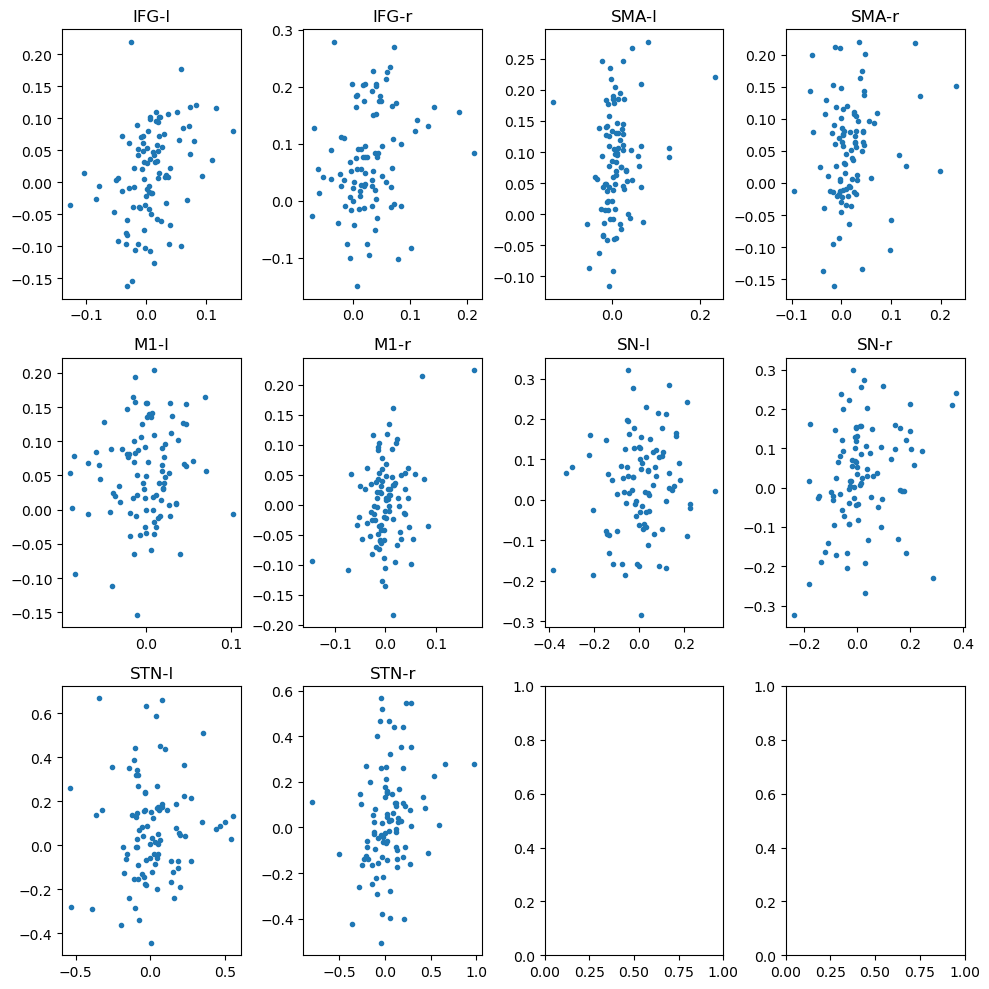

In [88]:
f, ax = plt.subplots(3,4, figsize=(10,10))
for i,roi in enumerate(combined['ROI'].unique()):
    ax.ravel()[i].plot(combined.loc[combined['ROI']==roi,'cope_roiwise'], combined.loc[combined['ROI']==roi,'cope'], '.')
    ax.ravel()[i].set_title(roi)
    
f.tight_layout()

In [46]:
roiwise_betas

,subject,ROI,cope
0,10159,IFG-l,-0.163079
1,10171,IFG-l,0.003605
2,10206,IFG-l,0.048325
3,10217,IFG-l,0.065325
4,10228,IFG-l,0.030859
...,...,...,...
1339,11128,Tha-r,0.020328
1340,11131,Tha-r,0.010730
1341,11143,Tha-r,-0.017326
1342,11149,Tha-r,0.058173


In [45]:
df

,roi,zstat_voxelwise,zstat_roiwise,zstat_voxelwise_sd,subject,hemisphere,ROI
0,Caudate,0.629850,1.292191,0.535506,10159,l,Caudate-l
1,Caudate,0.507234,0.702046,0.689344,10159,r,Caudate-r
2,IFG,-0.238517,-0.328902,0.685007,10159,l,IFG-l
3,IFG,0.535863,1.139136,0.840593,10159,r,IFG-r
4,Putamen,-0.029230,-0.453345,0.920320,10159,l,Putamen-l
...,...,...,...,...,...,...,...
2107,stn,-0.078108,-0.474071,0.449884,11156,r,stn-r
2108,tha,-0.178339,-2.856334,0.863898,11156,l,tha-l
2109,tha,-0.664170,-2.342823,0.798719,11156,r,tha-r
2110,vta,0.589113,0.829946,0.902021,11156,l,vta-l


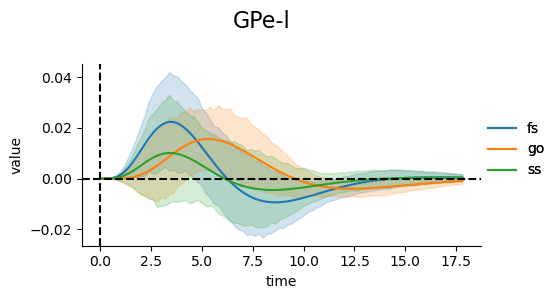

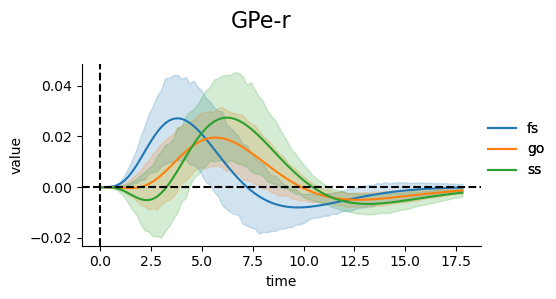

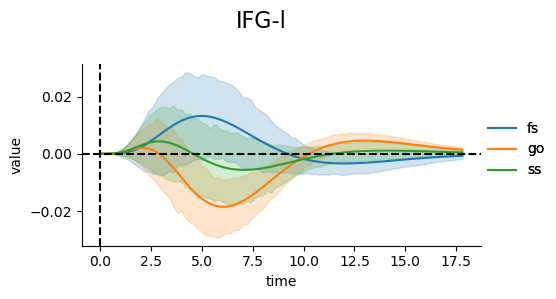

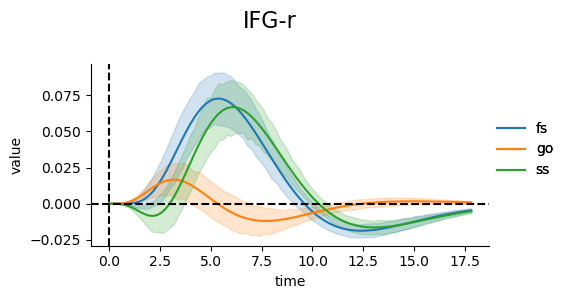

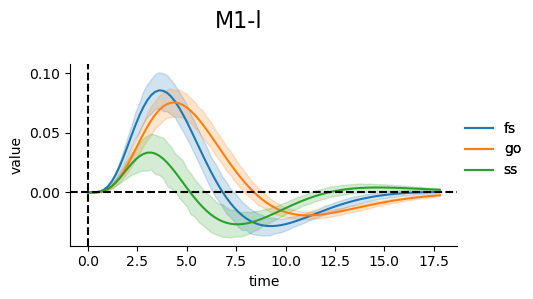

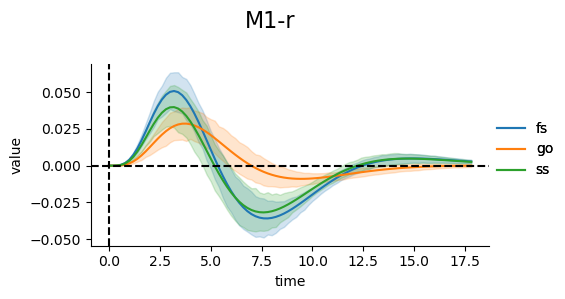

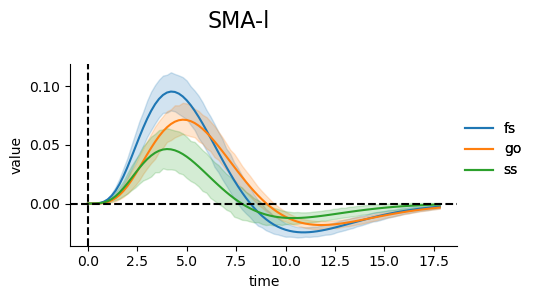

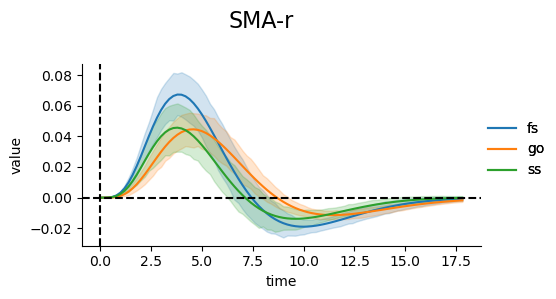

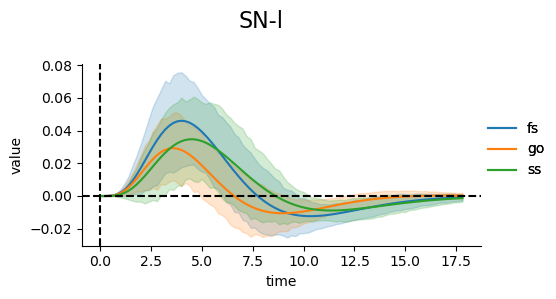

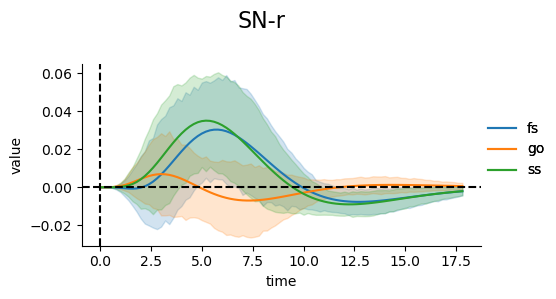

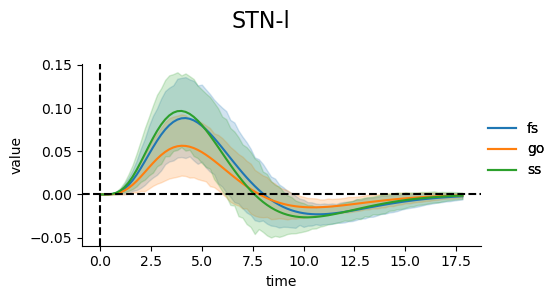

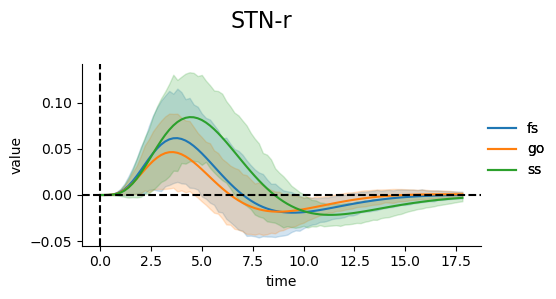

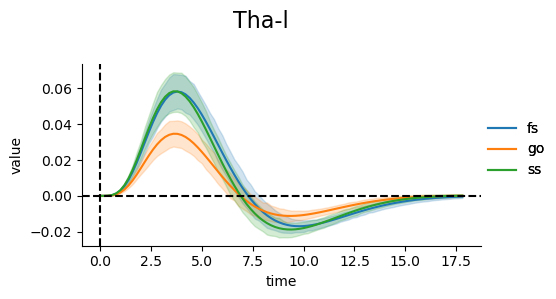

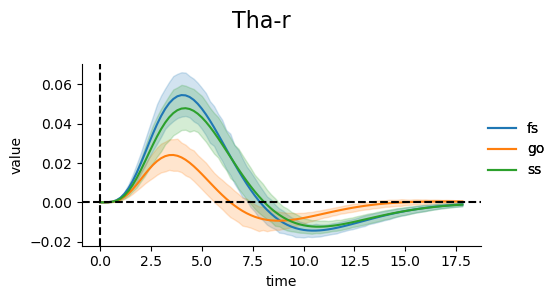

In [13]:
glm1.plot_groupwise_timecourses()

## fit motor glm

In [ ]:
if atlas_type == 'ATAG':
    gm_nuclei = ['M1', 'PreSMA', 'IFG','STN','SN'] #'ACC',
    include_rois = [hemi + roi for roi in gm_nuclei for hemi in ['l','r']]
    include_rois.remove('lIFG')
#     include_rois += ['ACC', 'THA']
elif atlas_type=='MASSP':
    gm_nuclei = ['Amg', 'Cl', 'GPe', 'GPi', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'Str', 'Tha', 'VTA']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
elif atlas_type == 'CORT':
    gm_nuclei = ['ACC','aSG','IFG','Ins','PaCG','pCC','postcG','precC','precGy','pSG','SMA','SPL']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
# elif atlas_type == 'ALL':
#     #     gm_nuclei = sorted(['IFG','ACC','M1','SMA','PaCG','Ins','GPe','GPi','RN','SN','STN','Str','Tha','VTA'])
#     gm_nuclei = ['ACC','IFG','Ins','M1','pSG','SMA','SPL','GPe','GPi','RN','SN','STN','Str','Tha','VTA']
#     include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
elif atlas_type == 'ALL':
    gm_nuclei = ['IFG','SMA','M1','SN','STN','GPe','Tha']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
    
# # just look at m1 for motor
# gm_nuclei_motor = ['M1']
# include_rois_motor = [roi + '-' + hemi for roi in gm_nuclei_motor for hemi in ['l', 'r']]

# include_events=['response_left','response_right','fs','ss','go']
include_events = ['response_left','response_right']
glm_m = fit_glm(timeseries=df, events=events, confounds=confounds, include_events=include_events, include_rois=include_rois)

## plotting

In [12]:
import copy

glm1_ar1 = copy.deepcopy(glm1)
# glm1_ar1 = copy.deepcopy(glm_m)

tc = glm1.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')

In [13]:
# motor_glm = copy.deepcopy(glm_m)

# tc = motor_glm.get_subjectwise_timecourses()
# tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')

# motor_glm.plot_subject_timecourses()
# motor_glm.plot_group_timecourses()

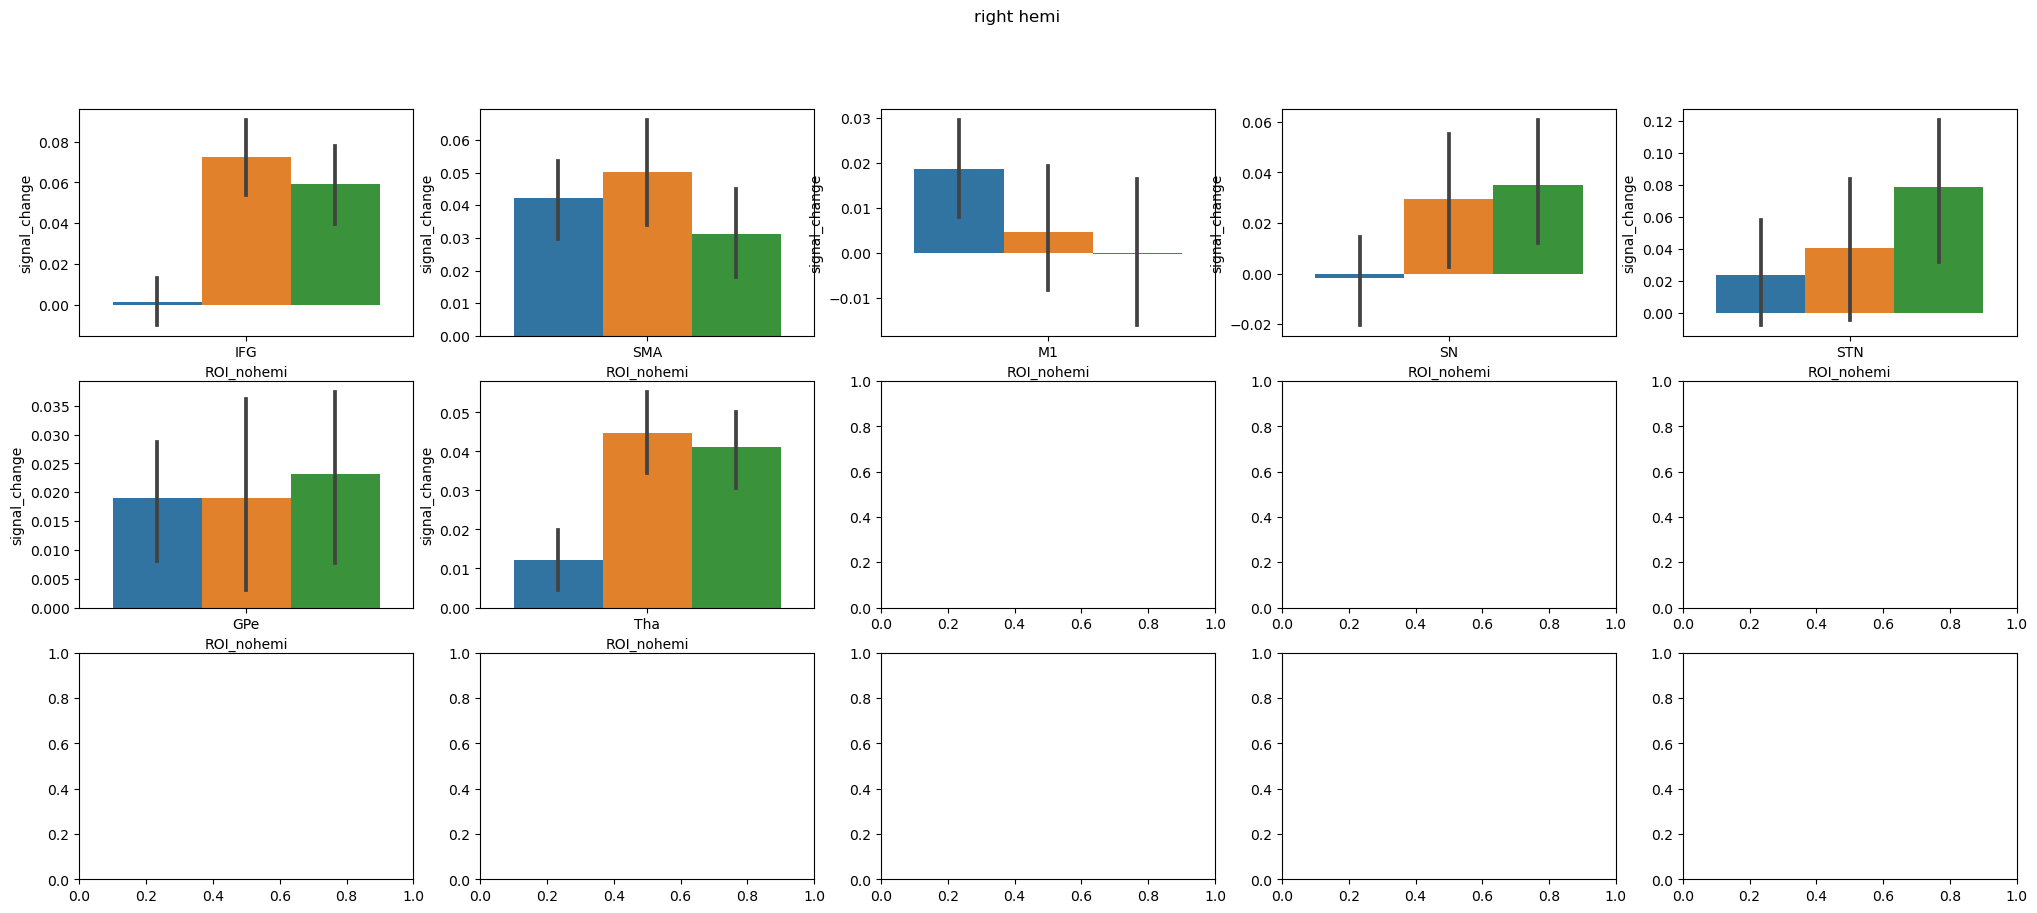

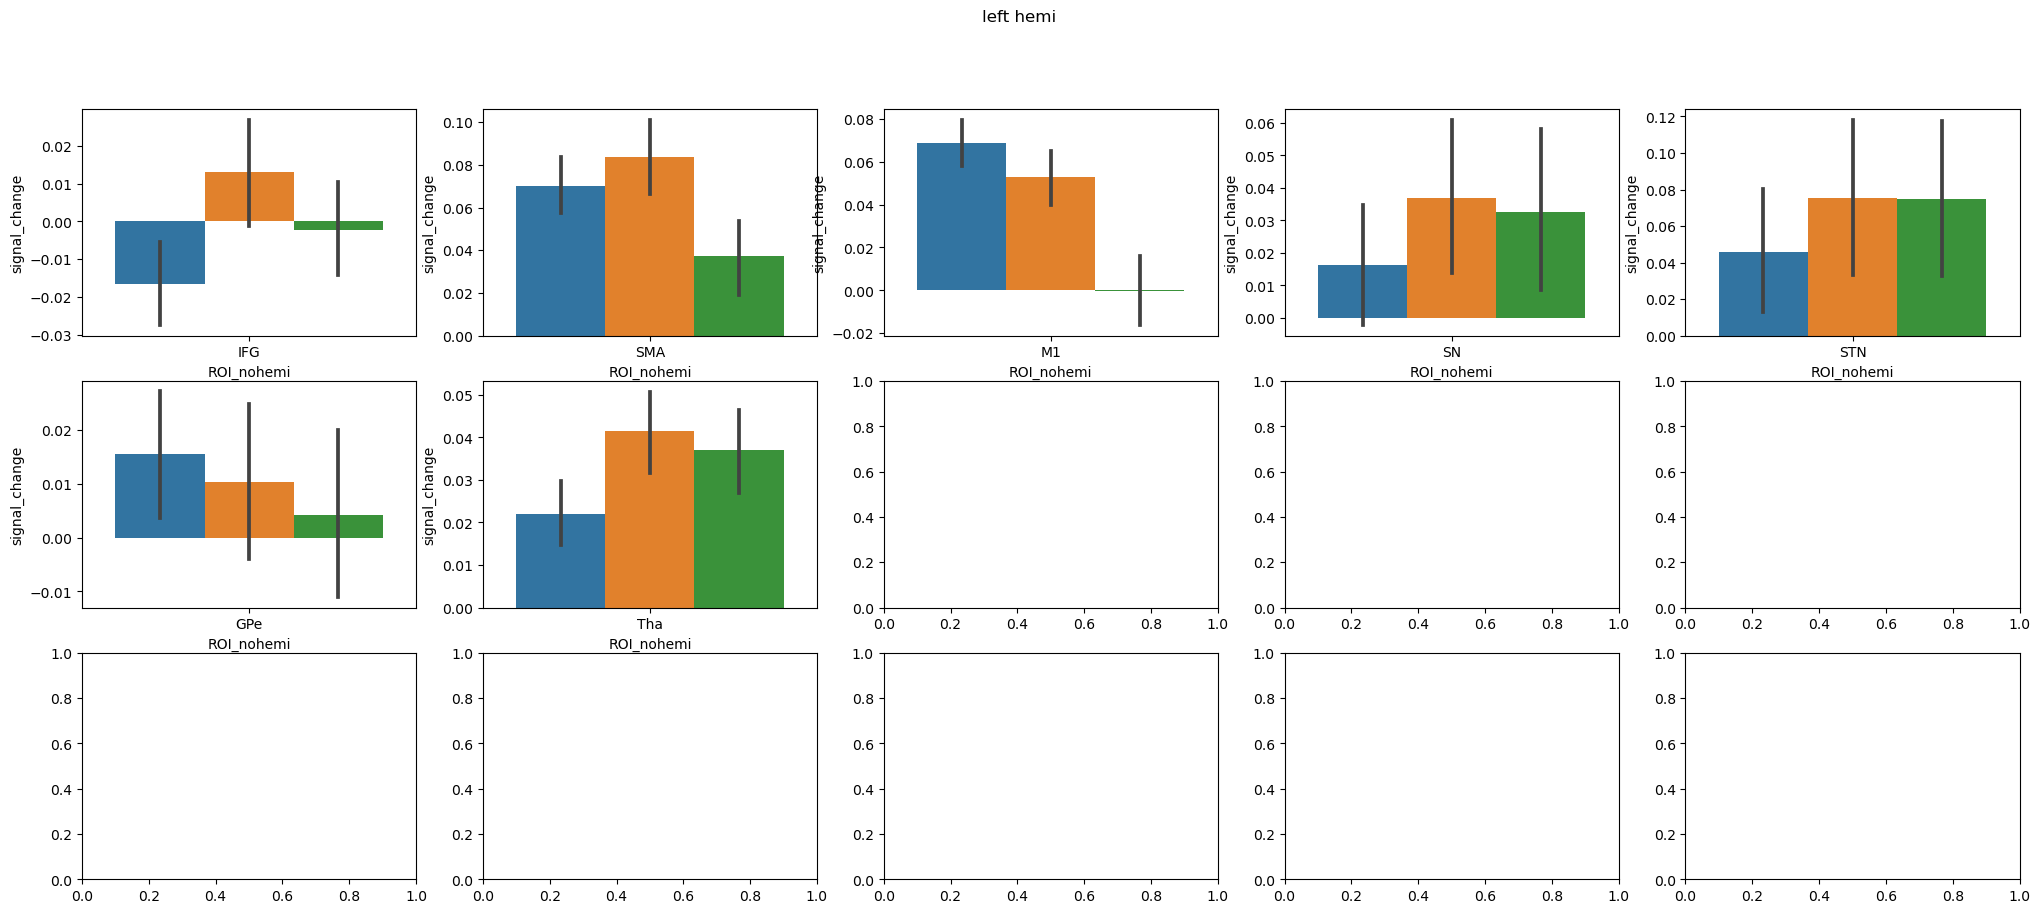

In [14]:
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go', 'fs', 'ss'], 'intercept', 'HRF')]              # Select only betas of interest

# contrast_betas = subjectwise_betas
contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='signal_change', ignore_index=False)
contrast_betas = contrast_betas.reset_index(level=1)

if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
    
f, axes = plt.subplots(3,5,figsize=(25,10))
f.suptitle('right hemi')
ax = axes.ravel()

for i, r in enumerate(gm_nuclei):
    sns.barplot(x='ROI_nohemi', y='signal_change', hue='event type', 
                data=contrast_betas.loc[(contrast_betas.hemisphere=='r') & (contrast_betas.ROI_nohemi==r)], ax=ax[i])
    ax[i].legend_.remove()

f, axes = plt.subplots(3,5,figsize=(25,10))
f.suptitle('left hemi')
ax = axes.ravel()

for i, l in enumerate(gm_nuclei):
    sns.barplot(x='ROI_nohemi', y='signal_change', hue='event type', 
                data=contrast_betas.loc[(contrast_betas.hemisphere=='l') & (contrast_betas.ROI_nohemi==l)], ax=ax[i])
    ax[i].legend_.remove()





p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SMA_fs v.s. SMA_ss: t-test paired samples with Bonferroni correction, P_val=3.150e-08 stat=6.354e+00
M1_go v.s. M1_fs: t-test paired samples with Bonferroni correction, P_val=2.843e-04 stat=4.467e+00
M1_fs v.s. M1_ss: t-test paired samples with Bonferroni correction, P_val=1.109e-06 stat=5.667e+00
SN_go v.s. SN_fs: t-test paired samples with Bonferroni correction, P_val=4.931e-03 stat=-3.749e+00
SN_fs v.s. SN_ss: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-8.329e-02
STN_go v.s. STN_fs: t-test paired samples with Bonferroni correction, P_val=9.377e-01 stat=-2.021e+00
STN_fs v.s. STN_ss: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-1.114e+00
GPe_go v.s. GPe_fs: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=6.109e-01
GPe_fs v.s. GPe_ss: t-test paire

Text(0.5, 80.7222222222222, 'ROI')

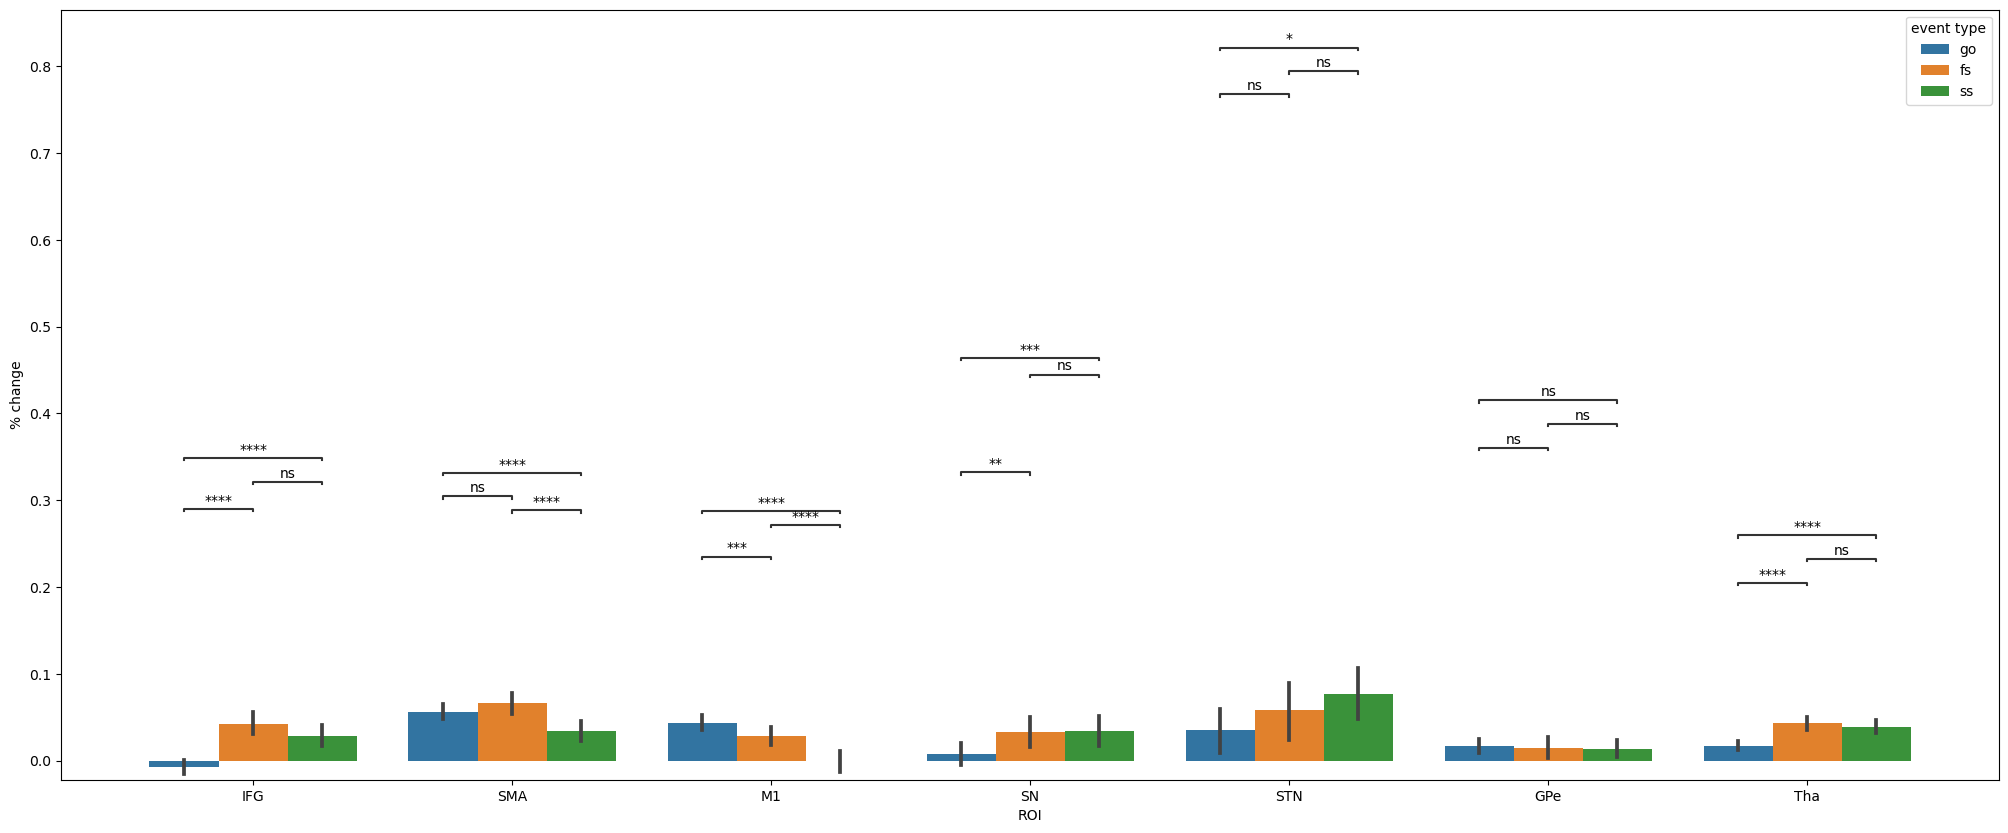

In [15]:
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go', 'fs', 'ss'], 'intercept', 'HRF')]              # Select only betas of interest

# contrast_betas = subjectwise_betas
contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='signal_change', ignore_index=False)
contrast_betas = contrast_betas.reset_index(level=1)

if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
    
f, ax = plt.subplots(1,1,figsize=(25,10))
sns.barplot(x='ROI_nohemi', y='signal_change', hue='event type', 
            data=contrast_betas, ax=ax)

box_pairs = []
for index in contrast_betas['ROI_nohemi'].unique():
    box_pairs = box_pairs + (list(itertools.combinations(list(itertools.combinations([index,'go', 'fs', 'ss'],2))[:3],2)))
    
# box_pairs = box_pairs[:1]
statannot.add_stat_annotation(
    ax,
    data=contrast_betas, 
    x='ROI_nohemi',
    y='signal_change',
    hue='event type',
#     hue_order=['go','fs','ss'],
    box_pairs=box_pairs,
    test="t-test_paired", #options=['t-test_ind', 't-test_welch', 't-test_paired','Mann-Whitney', 'Mann-Whitney-gt', 'Mann-Whitney-ls','Levene', 'Wilcoxon', 'Kruskal']
    text_format="star",
    loc="inside",
#     text_offset=-0.5,
#     line_offset_to_box=-0.5,
#     line_offset=-0.5,
#     use_fixed_offset=True
#     line_height=1
)

ax.set_ylabel('% change')
ax.set_xlabel('ROI')



In [16]:
# motor
all_betas = glm_m.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['response_left', 'response_right'], 'intercept', 'HRF')] # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference right - left
contrast_betas = contrast_betas.xs('response_right',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_right-left', ignore_index=False)

if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])

## recode to contralateral vs ipsilateral
contrast_betas['beta_contra-ipsi'] = contrast_betas['beta_right-left'].copy()
contrast_betas.loc[contrast_betas.hemisphere == 'r', 'beta_contra-ipsi'] *= -1
contrast_betas_motor = contrast_betas.copy()

## event glms
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe

# fs - go
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go', 'fs'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference fs - go
contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fs-go', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_fsgo = contrast_betas.copy()

# ss - fs
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['ss', 'fs'], 'intercept', 'HRF')]              # Select only betas of interest
# subjectwise_betas[['STN-l', 'STN-r', 'Str-l', 'Str-r']].melt(ignore_index=False).reset_index().to_csv('./download-for-steven/betas_SAT.csv')

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference fs - ss
contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fs-ss', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_fsss = contrast_betas.copy()

# go - ss
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go', 'ss'], 'intercept', 'HRF')]              # Select only betas of interest
# subjectwise_betas[['STN-l', 'STN-r', 'Str-l', 'Str-r']].melt(ignore_index=False).reset_index().to_csv('./download-for-steven/betas_SAT.csv')

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference ss - go
contrast_betas = contrast_betas.xs('ss',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_ss-go', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_ssgo = contrast_betas.copy()

##########
###########
###########
# now look just at absolute activtions with trial types
############

# fs
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['fs'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)#.groupby(level=0).diff()                   # Take against baseline fs
# contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fs', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
betas_fs = contrast_betas.copy()

# ss
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['ss'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)#.groupby(level=0).diff()                   # Take against baseline ss
# contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_ss', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
betas_ss = contrast_betas.copy()

# go
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)#.groupby(level=0).diff()                   # Take against baseline go
# contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_go', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
betas_go = contrast_betas.copy()

contrast_betas_fsgo.to_csv(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/roi_glm/{dataset}/contrast_betas_fsgo.tsv',sep='\t', index=True,header =True)
contrast_betas_fsss.to_csv(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/roi_glm/{dataset}/contrast_betas_fsss.tsv',sep='\t', index=True,header =True)
contrast_betas_ssgo.to_csv(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/roi_glm/{dataset}/contrast_betas_ssgo.tsv',sep='\t', index=True,header =True)

# look at significance

In [17]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

# absolute activation

In [18]:
tmp = betas_fs.groupby('ROI')['beta_fs'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_fs = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = betas_ss.groupby('ROI')['beta_ss'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_ss = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = betas_go.groupby('ROI')['beta_go'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_go = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

stat_fs, stat_ss, stat_go = stat_fs.reindex(rois_), stat_ss.reindex(rois_), stat_go.reindex(rois_)

In [19]:
display_side_by_side(stat_fs,stat_ss,stat_go, titles=['fs','ss','go'])

,t,p,fdr_significant,p_corrected,significance
IFG-l,1.761399,8.138830e-02,False,0.096771,
IFG-r,7.733654,1.091690e-11,True,0.0,***
SMA-l,9.676873,8.103056e-16,True,0.0,***
SMA-r,6.071348,2.595015e-08,True,0.0,***
M1-l,7.473864,3.803198e-11,True,0.0,***
M1-r,0.646974,5.192090e-01,False,0.519209,
SN-l,3.023993,3.207888e-03,True,0.005614,**
SN-r,2.191886,3.083141e-02,True,0.043164,*
STN-l,3.243815,1.628344e-03,True,0.003257,**
STN-r,1.752311,8.294695e-02,False,0.096771,


# contrast significance

In [20]:
tmp = contrast_betas_fsgo.groupby('ROI')['beta_fs-go'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_fsgo = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = contrast_betas_fsss.groupby('ROI')['beta_fs-ss'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_fsss = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = contrast_betas_ssgo.groupby('ROI')['beta_ss-go'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_ssgo = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = contrast_betas_motor.groupby('ROI')['beta_contra-ipsi'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_leftright = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

stat_fsgo, stat_fsss, stat_ssgo, stat_leftright = stat_fsgo.reindex(rois_), stat_fsss.reindex(rois_), stat_ssgo.reindex(rois_), stat_leftright.reindex(rois_)

stat_fsgo.to_csv(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/roi_glm/{dataset}/stat_fsgo.tsv',sep='\t', index=True,header =True)
stat_fsss.to_csv(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/roi_glm/{dataset}/stat_fsss.tsv',sep='\t', index=True,header =True)
stat_ssgo.to_csv(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/roi_glm/{dataset}/stat_ssgo.tsv',sep='\t', index=True,header =True)

In [21]:
display_side_by_side(stat_leftright,stat_fsss,stat_fsgo,stat_ssgo, titles=['contra-ipsilateral','fs > ss','fs > go','ss > go'])

,t,p,fdr_significant,p_corrected,significance
IFG-l,-0.312728,0.755173,False,0.985431,
IFG-r,0.065698,0.947756,False,0.985431,
SMA-l,-0.034899,0.972234,False,0.985431,
SMA-r,0.197407,0.843931,False,0.985431,
M1-l,-0.262734,0.793325,False,0.985431,
M1-r,1.648137,0.102628,False,0.718397,
SN-l,0.031134,0.975228,False,0.985431,
SN-r,-1.858495,0.066195,False,0.718397,
STN-l,0.026322,0.979056,False,0.985431,
STN-r,-1.079254,0.283207,False,0.929399,


## plot all 4 contrasts

In [22]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return m+h # only need highest 

def mean_confidence_interval_lower(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return m-h # only need highest 

def add_asteriks(ax_n, data, col_name, significance=0):
    l_count, r_count = 0, 0
    
    
#     new = contrast_betas_inccon.groupby(['ROI_nohemi','hemisphere'])['beta_inc-con'].apply(mean_confidence_interval).reset_index().set_index('ROI_nohemi')
#     new = new.loc[sorted(new.index,key=str.casefold)].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere'])
    roi_data = data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval).reset_index().set_index('ROI_nohemi')
#     roi_data = roi_data.loc[sorted(roi_data.index,key=str.casefold)].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere'])
    roi_data = roi_data.loc[roi_data.index].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere']).reindex(gm_nuclei,level=0)
    
    roi_data_lower = data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval_lower).reset_index().set_index('ROI_nohemi')
#     roi_data_lower = roi_data_lower.loc[sorted(roi_data_lower.index,key=str.casefold)].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere'])
    roi_data_lower = roi_data_lower.loc[roi_data_lower.index].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere']).reindex(gm_nuclei,level=0)
    
#     print(roi_data_lower)
#     for index, (y_val, region) in enumerate(zip(data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval), data.ROI.unique())):
    for index, (y_val, region, y_val_lower) in enumerate(zip(roi_data[col_name], data.ROI.unique(), roi_data_lower[col_name])):
#         print(significance)
#         print(region)
        if index%2 == 0:
            x_val = -0.26 + l_count
            l_count+=1
            if (aster:=len(significance[index])) == 2:
                x_val = x_val - 0.06
            elif aster == 3:
                x_val = x_val - 0.12
        else:
            x_val = 0.14 + r_count
            r_count+=1
            if (aster:=len(significance[index])) == 2:
                x_val = x_val - 0.06
            elif aster == 3:
                x_val = x_val - 0.12
        if y_val >= 0:
            ax[ax_n].text(x_val, y_val+0.005, significance[index])
        else:
            ax[ax_n].text(x_val, y_val_lower-0.017, significance[index])

/tmp/ipykernel_1806100/817140456.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
/tmp/ipykernel_1806100/817140456.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)


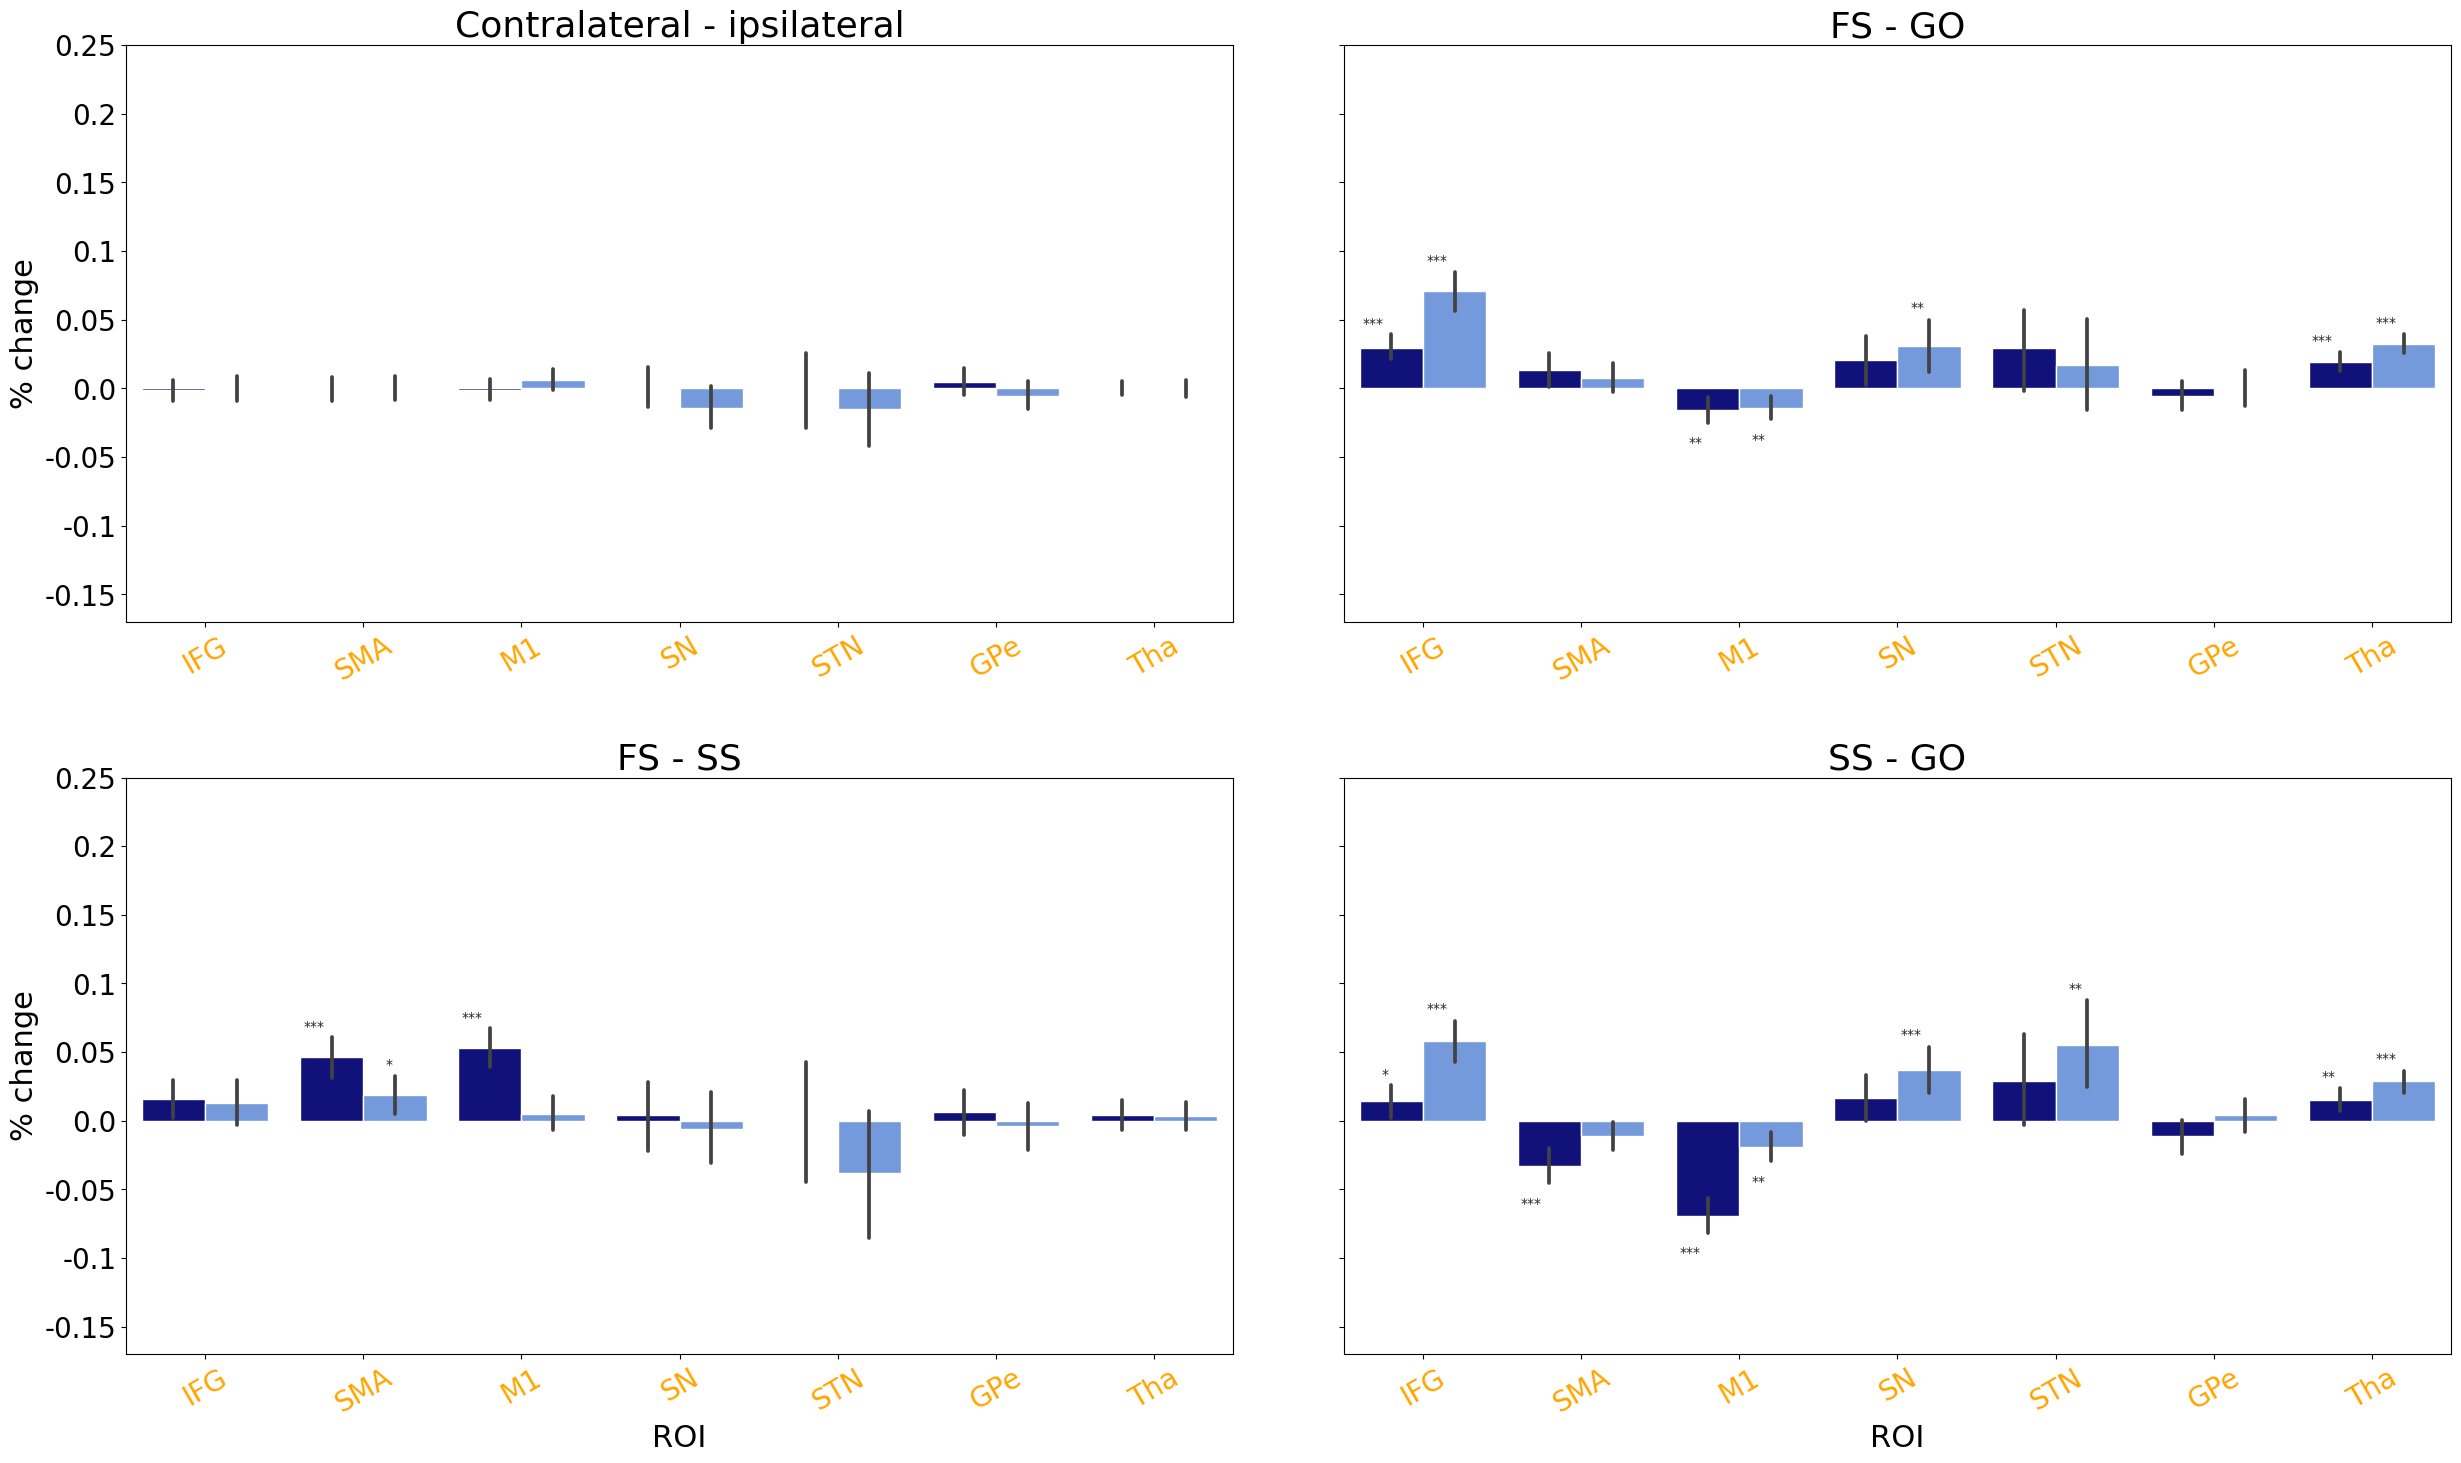

In [23]:
f, axes = plt.subplots(2,2, figsize=(30,17), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)
# sns.set_style('darkgrid')

with sns.axes_style("whitegrid"):

    # 1 ## MOTOR RESPONSE
    sns.barplot(x='ROI_nohemi', y='beta_contra-ipsi', hue='hemisphere', 
                data=contrast_betas_motor, ax=ax[0],palette=("darkblue","cornflowerblue"))
    ax[0].set_ylabel('% change', fontsize=22)
    ax[0].set_xlabel('')
    ax[0].legend_.remove()
    ax[0].set_title('Contralateral - ipsilateral', fontsize=26)
    ax[0].set(ylim=(-0.17,0.25))
    add_asteriks(0, contrast_betas_motor, 'beta_contra-ipsi', stat_leftright['significance'])
    # ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
    ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)


    ## 2
    sns.barplot(x='ROI_nohemi', y='beta_fs-go', hue='hemisphere', 
                data=contrast_betas_fsgo, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('')
    ax[1].set_xlabel('')
    ax[1].legend_.remove()
    ax[1].set_title('FS - GO', fontsize=26)
    ax[1].set(ylim=(-0.17,0.25))
    add_asteriks(1, contrast_betas_fsgo, 'beta_fs-go', stat_fsgo['significance'])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[1].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)

    ## 3
    sns.barplot(x='ROI_nohemi', y='beta_fs-ss', hue='hemisphere', 
                data=contrast_betas_fsss, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('% change', fontsize=22)
    ax[2].set_xlabel('ROI', fontsize=22)
    ax[2].legend_.remove()
    ax[2].set_title('FS - SS', fontsize=26)
    ax[2].set(ylim=(-0.17,0.25))
    add_asteriks(2, contrast_betas_fsss, 'beta_fs-ss', stat_fsss['significance'])
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)

    ## 4
    sns.barplot(x='ROI_nohemi', y='beta_ss-go', hue='hemisphere', 
                data=contrast_betas_ssgo, ax=ax[3],palette=("darkblue","cornflowerblue"))
    ax[3].set_ylabel('')
    ax[3].set_xlabel('ROI', fontsize=22)
    ax[3].legend_.remove()
    ax[3].set_title('SS - GO', fontsize=26)
    ax[3].set(ylim=(-0.17,0.25))
    add_asteriks(3, contrast_betas_ssgo, 'beta_ss-go', stat_ssgo['significance'])
    ax[3].set_xticklabels(ax[3].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[3].set_yticklabels(ax[3].get_yticks().round(2),fontsize=20)

    for x in range(4) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]

#     f.savefig('figure_download_scott/GLM_ROI_SST_contrasts.pdf', bbox_inches='tight')

/tmp/ipykernel_1806100/287470094.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
/tmp/ipykernel_1806100/287470094.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)


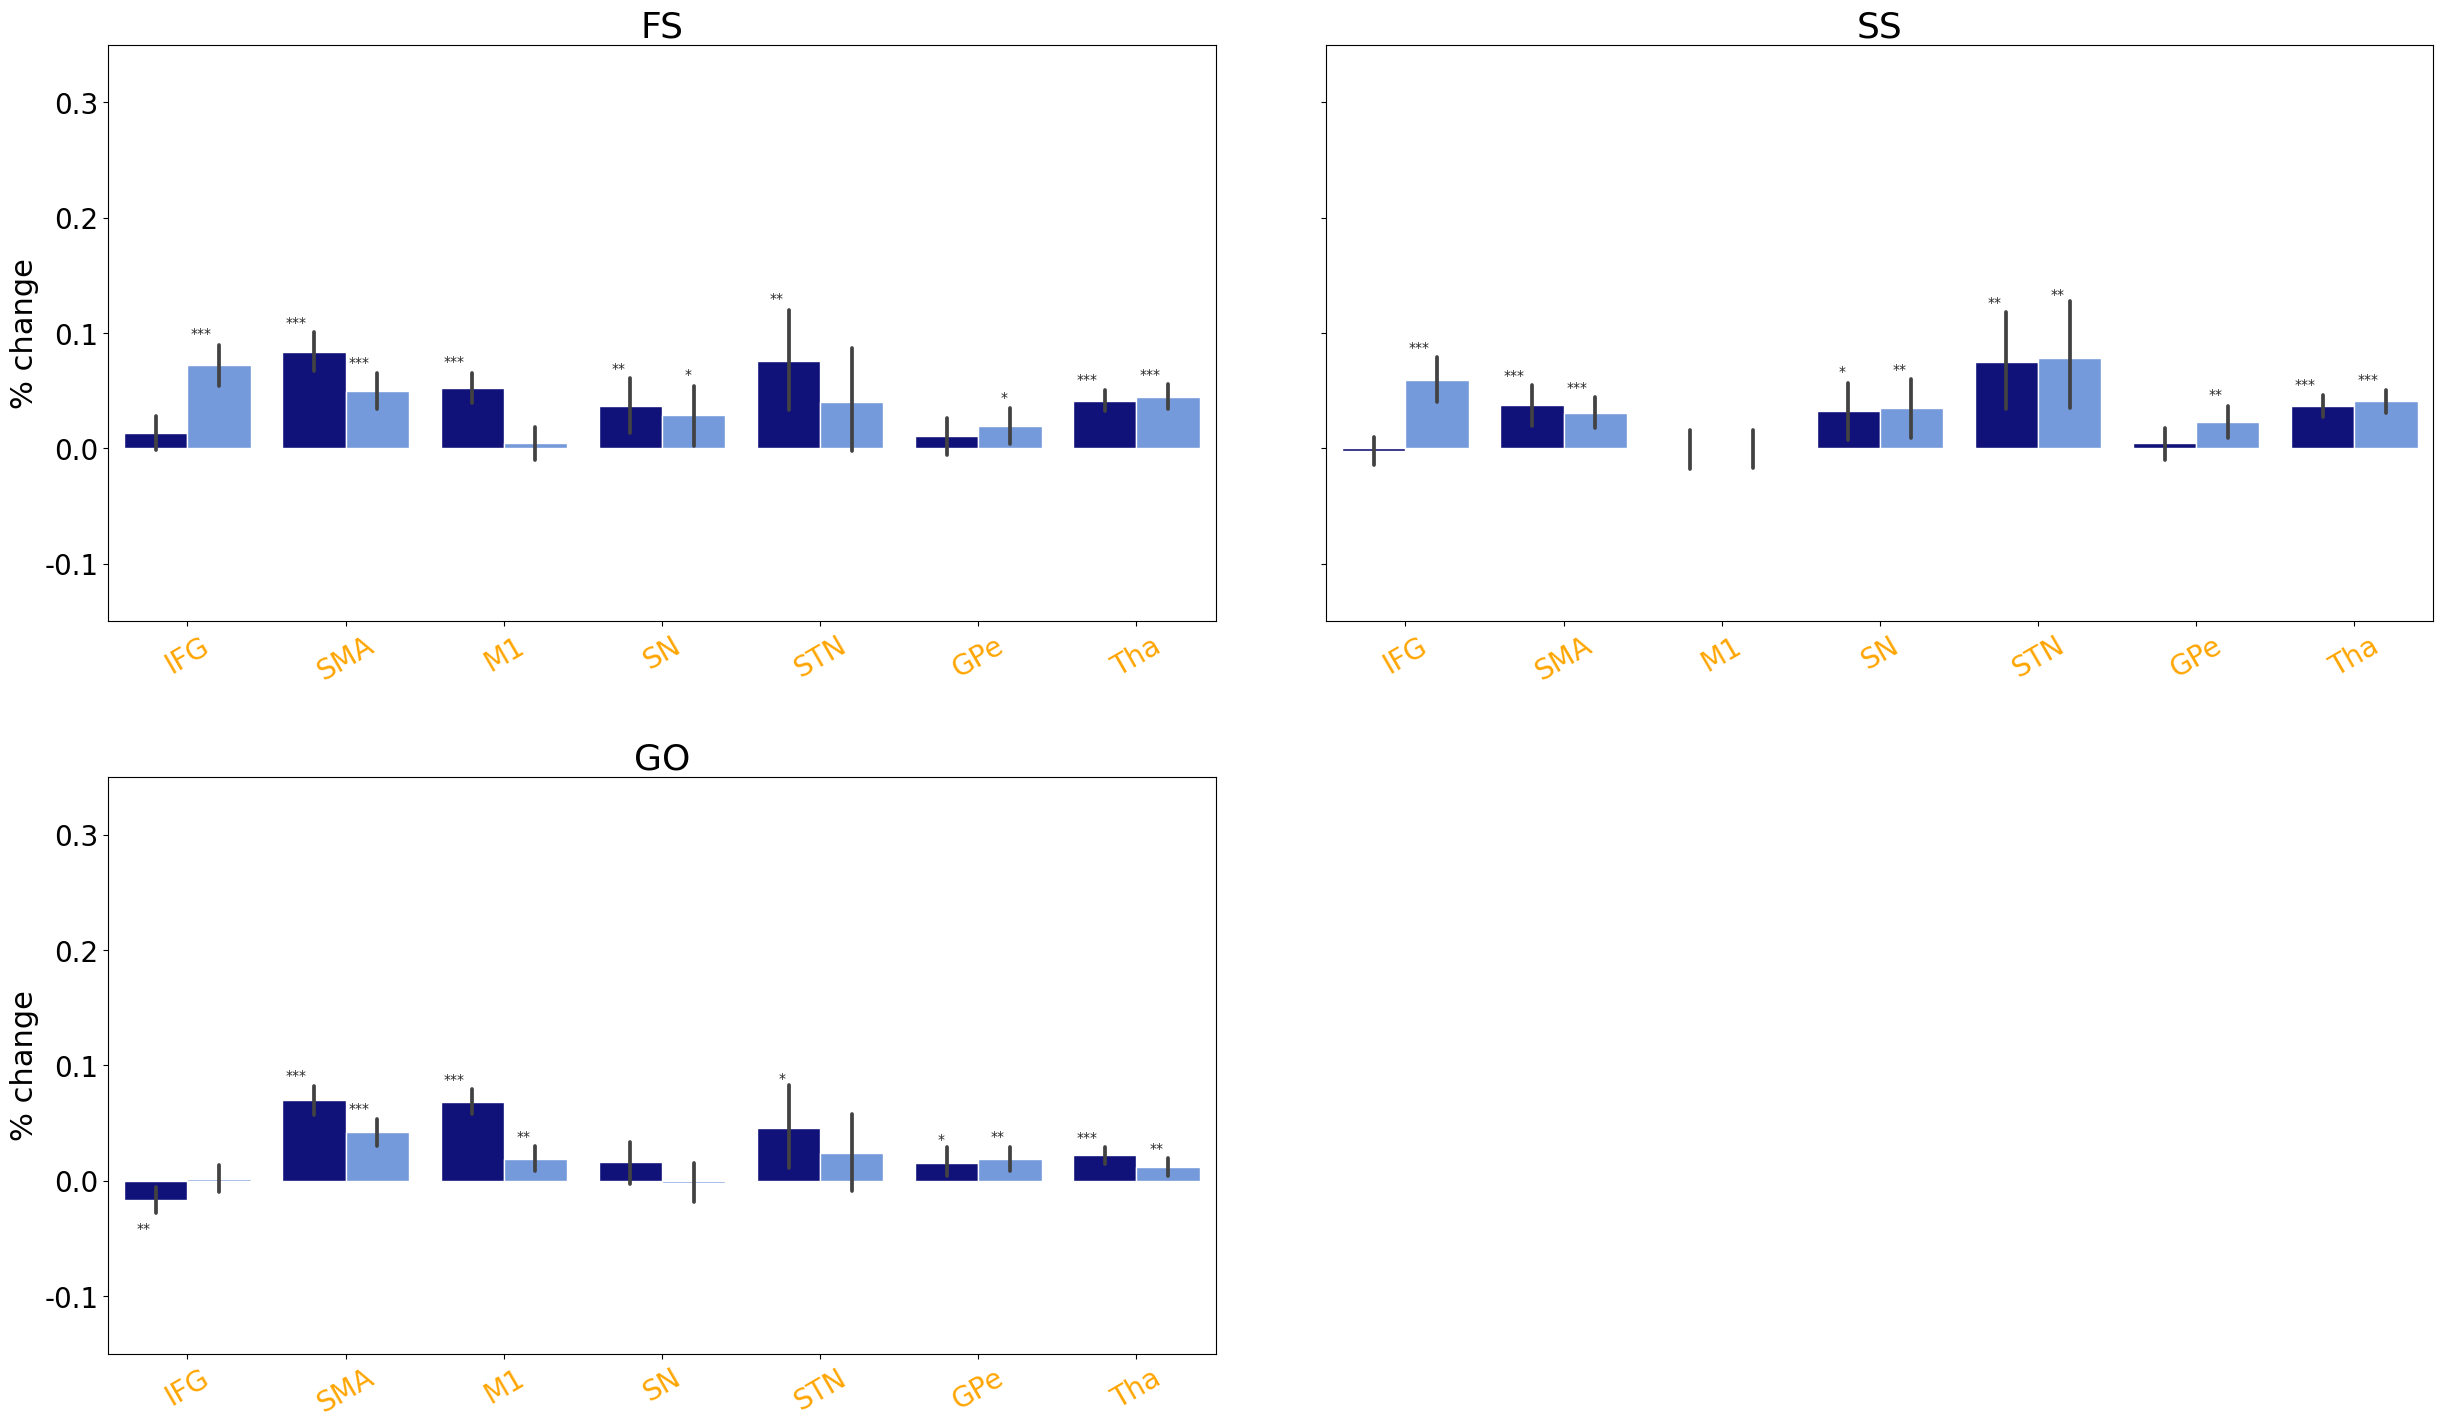

In [24]:
f, axes = plt.subplots(2,2, figsize=(30,17), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)
# sns.set_style('darkgrid')

with sns.axes_style("whitegrid"):

    ## 1 ## FS
    sns.barplot(x='ROI_nohemi', y='beta_fs', hue='hemisphere', 
                data=betas_fs, ax=ax[0],palette=("darkblue","cornflowerblue"))
    ax[0].set_ylabel('% change', fontsize=22)
    ax[0].set_xlabel('')
    ax[0].legend_.remove()
    ax[0].set_title('FS', fontsize=26)
    ax[0].set(ylim=(-0.15,0.35))
    add_asteriks(0, betas_fs, 'beta_fs', stat_fs['significance'])
    # ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
    ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)

    ## 2 SS
    sns.barplot(x='ROI_nohemi', y='beta_ss', hue='hemisphere', 
                data=betas_ss, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('')
    ax[1].set_xlabel('')
    ax[1].legend_.remove()
    ax[1].set_title('SS', fontsize=26)
    ax[1].set(ylim=(-0.15,0.35))
    add_asteriks(1, betas_ss, 'beta_ss', stat_ss['significance'])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)

    ## 3 GO
    sns.barplot(x='ROI_nohemi', y='beta_go', hue='hemisphere', 
                data=betas_go, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('% change', fontsize=22)
    ax[2].set_xlabel('', fontsize=22)
    ax[2].legend_.remove()
    ax[2].set_title('GO', fontsize=26)
    ax[2].set(ylim=(-0.15,0.35))
    add_asteriks(2, betas_go, 'beta_go', stat_go['significance'])
    # ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    
    for x in range(4) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]
        
    ax[3].set_visible(False)
    
#     f.savefig('figure_download_scott/GLM_ROI_SST_supplementary.pdf', bbox_inches='tight')

# random code

In [ ]:
# load and save glm info for model based analysis
# absolute values for FS, SS and GO trials for each region
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
fs_betas = subjectwise_betas.loc[(slice(None),['fs'], 'intercept', 'HRF')]              # Select only betas of interest
ss_betas = subjectwise_betas.loc[(slice(None),['ss'], 'intercept', 'HRF')]              # Select only betas of interest
go_betas = subjectwise_betas.loc[(slice(None),['go'], 'intercept', 'HRF')]              # Select only betas of interest

# fs_betas.to_csv('scott/fs_betas_tsv.tsv',sep='\t')
# ss_betas.to_csv('scott/ss_betas_tsv.tsv',sep='\t')
# go_betas.to_csv('scott/go_betas_tsv.tsv',sep='\t')
# fs_reg = 



# # fs - go
# subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
# subjectwise_betas = subjectwise_betas.loc[(slice(None),['fs'], 'intercept', 'HRF')]              # Select only betas of interest

# contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference SPD-ACC
# contrast_betas = contrast_betas.xs('fs',level=1)
# contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fs-go', ignore_index=False)
# if atlas_type == 'ATAG':
#     contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
#     contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
# else:
#     contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
#     contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
# contrast_betas_fsgo = contrast_betas.copy()